# Cas Kaggle

**Nerea de La Torre Veguillas 1669013**

**Helena Boneu Vidal 1673129**

Hem utilitzat el dataset **Harry Potter Dataset**.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import re
import time
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RFE
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import f1_score, classification_report, r2_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, cross_val_predict
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

Carreguem el **dataset**:

En un principi, quan vam observar el datset per primer cop, vam veure que hi havien bastantes característiques dels personatges que no hi eren, per això vam decidir fer una cerca a internet i buscar la informació faltant. Tot i així, no vam poder aconseguir trobar totes les dades necessàries, però ens va ajudar a obtenir un dataset més complet per utilitzar en la nostra predicció.

In [2]:
df = 'C:/Users/helen/OneDrive/Documentos/3r Carrera/1r semestre/Aprenentatge Computacional/Kaggle/data/harry-potter-dataset/Characters.csv' # 'C:/Users/nerea/OneDrive/Escritorio/cosas uni/3r/AP/kaggle/data/harry-potter-dataset/Characters.csv'

df = pd.read_csv(df, delimiter=';')
df.head(5)

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills,Birth,Death
0,1,Harry James Potter,Male,Student,Gryffindor,"11"" Holly phoenix feather",Stag,Human,Half-blood,Black,Bright green,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...,31 July 1980,NaN
1,2,Ronald Bilius Weasley,Male,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,Human,Pure-blood,Red,Blue,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping,1 March 1980,NaN
2,3,Hermione Jean Granger,Female,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,Human,Muggle-born,Brown,Brown,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything,"19 September, 1979",NaN
3,4,Albus Percival Wulfric Brian Dumbledore,Male,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,Human,Half-blood,Silver,Blue,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...,Late August 1881,"30 June, 1997"
4,5,Rubeus Hagrid,Male,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",NaN,Half-Human/Half-Giant,Part-Human (Half-giant),Black,Black,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...,6 December 1928,NaN


# 1. EDA AND PREPROCESSING

A continuació, mirem si hi ha **NaNs** en el dataset.

In [3]:
print("Columnes amb NaNs:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)

nan_columns = df.columns[df.isna().sum()>0].tolist()
print('\nNúmero de NaNs per columna:\n')
print (df.loc[:,nan_columns].isna().sum())

Columnes amb NaNs:

Job              4.729730
House           15.540541
Patronus         4.729730
Blood status     8.108108
Hair colour      0.675676
Eye colour      12.837838
Skills           5.405405
Birth            8.783784
Death           69.594595
dtype: float64

Número de NaNs per columna:

Job               7
House            23
Patronus          7
Blood status     12
Hair colour       1
Eye colour       19
Skills            8
Birth            13
Death           103
dtype: int64


Com que volem fer la predicció de les cases dels personatges, no ens interessa tenir personatges que no tenen casa. Per aquesta raó, eliminem les files dels quals **no** tenen **casa**. A més, hi ha personatges que directament no poden tenir casa, ja que no pertanyen al món màgic.
També eliminarem als personatges que pertanyin a altres escoles de màgia, ja que solament volem fer la predicció de les cases de Hogwarts.

In [4]:
df = df.dropna(subset=['House'])

valid_houses = ['Gryffindor', 'Hufflepuff', 'Slytherin', 'Ravenclaw']

df = df[df['House'].isin(valid_houses)]

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills,Birth,Death
0,1,Harry James Potter,Male,Student,Gryffindor,"11"" Holly phoenix feather",Stag,Human,Half-blood,Black,Bright green,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...,31 July 1980,NaN
1,2,Ronald Bilius Weasley,Male,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,Human,Pure-blood,Red,Blue,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping,1 March 1980,NaN
2,3,Hermione Jean Granger,Female,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,Human,Muggle-born,Brown,Brown,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything,"19 September, 1979",NaN
3,4,Albus Percival Wulfric Brian Dumbledore,Male,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,Human,Half-blood,Silver,Blue,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...,Late August 1881,"30 June, 1997"
4,5,Rubeus Hagrid,Male,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",NaN,Half-Human/Half-Giant,Part-Human (Half-giant),Black,Black,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...,6 December 1928,NaN


També veiem que les característiques **Birth** i **Death** no són rellevants per a la nostra predicció. Per tant, les podem eliminar del nostre dataset.

In [5]:
df = df.drop(columns=['Birth', 'Death'])
df.keys()

Index(['Id', 'Name', 'Gender', 'Job', 'House', 'Wand', 'Patronus', 'Species',
       'Blood status', 'Hair colour', 'Eye colour', 'Loyalty', 'Skills'],
      dtype='object')

A continuació, mirem les **columnes** que tenen **NaNs**.

In [6]:
print("Columnes amb NaNs:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)

nan_columns = df.columns[df.isna().sum()>0].tolist()
print('\nNúmero de NaNs per columna:\n')
print (df.loc[:,nan_columns].isna().sum())

Columnes amb NaNs:

Job              4.132231
Patronus         4.958678
Blood status     6.611570
Eye colour      11.570248
Skills           5.785124
dtype: float64

Número de NaNs per columna:

Job              5
Patronus         6
Blood status     8
Eye colour      14
Skills           7
dtype: int64


Característica **Eye colour**:

Per omplir els NaNs d'aquesta característica farem servir l'algorisme **KNN**. Per aquesta raó, utilitzarem les característiques **Hair colour** i **Gender**, ja que són dues característiques importants per fer la predicció de **Eye colour**.

Per tant, primer haurem de fer **encoding** de les dos característiques, ja que són **variables categòriques**.

In [7]:
numeric_features = df.select_dtypes(np.number).keys()
non_numeric = ['Hair colour', 'Gender']
df.loc[:,non_numeric] = df.loc[:,non_numeric].apply(LabelEncoder().fit_transform)

A continuació, haurem de fer **encoding** de la característica **Eye colour**, ja que també l'utilitzarem en la predicció dels Nans. Però en aquest cas, com que tenim alguns Nans, el que farem és només convertir a númeric els valors que no ho són.

In [8]:
non_numeric = ['Eye colour']

for columna in non_numeric:
    non_nan_df = df[columna].dropna()
    df.loc[non_nan_df.index, columna] = LabelEncoder().fit_transform(non_nan_df)

Ara ja podem aplicar un **KNN** per trobar la característica **Eye colour** dels personatges que no la tenen.

In [9]:
imputer = KNNImputer(n_neighbors=5)
df['Eye colour'] = imputer.fit_transform(df[['Eye colour', 'Gender', 'Hair colour']])

df['Eye colour'] = df['Eye colour'].round().astype(int)  # Si el nombre és un float, l'arrodonim i el convertim a int

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills
0,1,Harry James Potter,1,Student,Gryffindor,"11"" Holly phoenix feather",Stag,Human,Half-blood,2,4,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...
1,2,Ronald Bilius Weasley,1,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,Human,Pure-blood,15,1,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping
2,3,Hermione Jean Granger,0,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,Human,Muggle-born,5,5,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything
3,4,Albus Percival Wulfric Brian Dumbledore,1,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,Human,Half-blood,20,1,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...
4,5,Rubeus Hagrid,1,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",NaN,Half-Human/Half-Giant,Part-Human (Half-giant),2,0,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...


Característica **Species**:

En aquesta categoria, el primer que hem fet a sigut borrar els parèntesis explicatius que tenien alguns personatges que són **Human**, ja que només ens interesa saber directament la seva espècie.

In [10]:
# Eliminem si hi ha algun espai al final
df['Species'] = df['Species'].str.strip()

# Eliminem els parèntesis explicatius
df['Species'] = df['Species'].str.replace(r'\s*\(.*?\)', '', regex=True)

df['Species'].unique()

array(['Human', 'Half-Human/Half-Giant', 'Werewolf', 'Ghost'],
      dtype=object)

A més, com que **no** tenim **NaNs** en aquesta característica, podem fer **encoding** de tots els seus valors.

In [11]:
numeric_features = df.select_dtypes(np.number).keys()
non_numeric = ['Species']
df.loc[:,non_numeric] = df.loc[:,non_numeric].apply(LabelEncoder().fit_transform)
df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills
0,1,Harry James Potter,1,Student,Gryffindor,"11"" Holly phoenix feather",Stag,2,Half-blood,2,4,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...
1,2,Ronald Bilius Weasley,1,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,Pure-blood,15,1,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping
2,3,Hermione Jean Granger,0,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,Muggle-born,5,5,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything
3,4,Albus Percival Wulfric Brian Dumbledore,1,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,Half-blood,20,1,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...
4,5,Rubeus Hagrid,1,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",NaN,1,Part-Human (Half-giant),2,0,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...


Característica **Blood status**:

A aquesta característica també apliquem un **KNN** per trobar els valors que ens falten.

En aquest cas, el procés serà igual al de la característica **Eye colour**. En primer lloc, transformarem només els valors no NaNs a valors numèrics i a continuació, ja podrem fer la predicció.

In [12]:
non_numeric = ['Blood status']

for columna in non_numeric:
    non_nan_df = df[columna].dropna()
    df.loc[non_nan_df.index, columna] = LabelEncoder().fit_transform(non_nan_df)

Ara ja podem aplicar un **KNN** per trobar la característica **Blood status** dels personatges que no la tenen. En aquest cas, per fer la predicció utilitzarem la característica **Species** i també **Blood status**.

In [13]:
imputer = KNNImputer(n_neighbors=5)
df['Blood status'] = imputer.fit_transform(df[['Blood status', 'Species']])

df['Blood status'] = df['Blood status'].round().astype(int)

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills
0,1,Harry James Potter,1,Student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,4,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...
1,2,Ronald Bilius Weasley,1,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,1,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping
2,3,Hermione Jean Granger,0,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,5,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything
3,4,Albus Percival Wulfric Brian Dumbledore,1,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,1,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...
4,5,Rubeus Hagrid,1,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,0,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...


Característica **Job**:

Podem veure que hi ha **personatges** que tenen **més d'una feina**, per tant, el primer que farem serà **separar** les diferents feines en diverses **columnes**.

A més, mirarem primer quin és el màxim de feines que pot tenir un personatge. D'aquesta manera sabrem quantes columnes haurem de crear.

In [14]:
df['Job'] = df['Job'].str.strip()

df['Job'] = df['Job'].str.replace(r'\s*\(.*?\)', '', regex=True)

# Contem quantes feines té cada personatge, sabent que cada feina està separada per '|' i ignorant els NaNs
df['Job_Count'] = df['Job'].apply(lambda x: len(x.split('|')) if pd.notna(x) else 0)

# Filtrem les files que tenen més d'una feina
multiple_jobs = df[df['Job_Count'] > 1]

print("Personatges amb més d'una feina:")
print(multiple_jobs[['Name', 'Job', 'Job_Count']])

print("\nEl màxim de feines que te algún dels personatges és de",max(multiple_jobs['Job_Count']),".")

Personatges amb més d'una feina:
                      Name                                                Job  \
4            Rubeus Hagrid  Keeper of Keys and Grounds | Professor of Care...   
16  Percy Ignatius Weasley  Student|Prefect|  Personal assistant to Barty ...   
29      Minerva McGonagall  Professor of Transfiguration | Head of Gryffindor   
36         Filius Flitwick            Professor of Charms | Head of Ravenclaw   
45           Severus Snape           Professor of Potions | Head of Slytherin   
50   Dolores Jane Umbridge  Professor of Defence Against the Dark Arts | D...   
81           Pomona Sprout  Professor of Herbology | Head of Hufflepuff House   
94    Kingsley Shacklebolt                        Auror  | Minister for Magic   
98        Rufus Scrimgeour           Head of Auror Office| Minister for Magic   

    Job_Count  
4           2  
16          3  
29          2  
36          2  
45          2  
50          2  
81          2  
94          2  
98          

Com que hem vist que el **màxim** de **feines** és de **3**, crearem **3 columnes** addicionals separant les feines de cada personatge. Les columnes que crearem seran:

* **Job_1** (per la 1ra feina)
* **Job_2** (per la 2na feina)
* **Job_3** (per la 3ra feina)

In [15]:
# Separem les feines en 3 columnes
feines_separades = df['Job'].apply(lambda x: x.split('|') if pd.notna(x) else []).apply(pd.Series)

# Canviem el nom de les columnes
feines_separades.columns = [f'Job_{i+1}' for i in range(feines_separades.shape[1])]

# Afegim les columnes al df
df = pd.concat([df, feines_separades], axis=1)

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills,Job_Count,Job_1,Job_2,Job_3
0,1,Harry James Potter,1,Student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,4,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...,1,Student,NaN,NaN
1,2,Ronald Bilius Weasley,1,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,1,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping,1,Student,NaN,NaN
2,3,Hermione Jean Granger,0,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,5,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything,1,Student,NaN,NaN
3,4,Albus Percival Wulfric Brian Dumbledore,1,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,1,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...,1,Headmaster,NaN,NaN
4,5,Rubeus Hagrid,1,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,0,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...,2,Keeper of Keys and Grounds,Professor of Care of Magical Creatures,NaN


A continuació, **agruparem** les feines de cada personatge en feines més globals. A més, els personatges que tinguin més d'una feina, triarem per a aquests la que és repeteix més vegades d'entre els personatges que només en tenen una.

In [16]:
# Creem un diccionari per agrupar feines similars
feines_similars = {
    'Professor': ['Professor', 'Defence Against the Dark Arts'],
    'Founder/Ghost Gryffindor': ['Gryffindor'],
    'Founder/Ghost Slytherin': ['Slytherin'],
    'Founder/Ghost Hufflepuff': ['Hufflepuff'],
    'Founder/Ghost Ravenclaw': ['Ravenclaw'],
    'School Head' : ['Headmaster', 'Headmistress'],
    'Gringotts' : ['Gringotts'],
    'Hogwarts service' : ['Matron', 'Flying Instructor', 'Astronomer', 'keeper of keys'],
    'Magical Government' : ['Magical', 'Muggle Artefacts'],
    'Death eater' : ['unspeakable', 'voldemort', 'executioner'],
    'Barman' : ['barman'],   
    'Quidditch' : ['quidditch'],
    'Head of House' : ['head'],
    'Personal Assistant' : ['Personal assistant']              
}

def agrupar_feina(feina):
    # Ens assegurem que les paraules estiguin en minúscules i sense espais addicionals
    feina = feina.strip().lower()
    
    for categoria, similares in feines_similars.items():
        # Comparem la feina amb les paraules de la llista
        llista = [item.strip().lower() for item in similares]
        paraules_dividides = []
        for paraula in llista:
            paraula_separada = paraula.split(' ')
            paraules_dividides.append(' '.join(paraula_separada))
        for i in paraules_dividides:
             if i in feina:
                return categoria.lower()
    return feina

# Filtrem els personatges que tenen 1, 2 o 3 feines
df_job_1 = df[df['Job_Count'] == 1].copy()
df_job_2 = df[df['Job_Count'] == 2].copy()
df_job_3 = df[df['Job_Count'] == 3].copy()

# Ens guardem també els personatges que no tenen cap feina
df_sense_job = df[df['Job_Count'] == 0]

# Apliquem la funció per agrupar les feines més similars de la columna Job_1
df_job_1['Job_1_Agrupat'] = df_job_1['Job_1'].apply(agrupar_feina)

# Apliquem la funció per agrupar les feines més similars de la columna Job_2
df_job_2['Job_1_Agrupat'] = df_job_2['Job_1'].apply(agrupar_feina)
df_job_2['Job_2_Agrupat'] = df_job_2['Job_2'].apply(agrupar_feina)

# Apliquem la funció per agrupar les feines més similars de la columna Job_3
df_job_3['Job_1_Agrupat'] = df_job_3['Job_1'].apply(agrupar_feina)
df_job_3['Job_2_Agrupat'] = df_job_3['Job_2'].apply(agrupar_feina)
df_job_3['Job_3_Agrupat'] = df_job_3['Job_3'].apply(agrupar_feina)

# Contem quantes vegades és repeteixen les feines de la columna Job_1
feines_repetides_job_1 = df_job_1['Job_1_Agrupat'].value_counts()

print("Feines repetides Job_1:\n")
print(feines_repetides_job_1)

df_tot = pd.concat([df_sense_job, df_job_1, df_job_2, df_job_3], ignore_index=True, sort=False)

df_tot = df_tot.sort_values(by='Id')

df_tot.head()

Feines repetides Job_1:

Job_1_Agrupat
student                     55
professor                    9
auror                        8
death eater                  7
magical government           4
hogwarts service             3
minister for magic           3
founder/ghost hufflepuff     2
founder/ghost gryffindor     2
founder/ghost ravenclaw      2
founder/ghost slytherin      2
housewife                    2
school head                  1
wandmaker                    1
gringotts                    1
dragonologist                1
school governor              1
barman                       1
arithmancy                   1
founder                      1
Name: count, dtype: int64


,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills,Job_Count,Job_1,Job_2,Job_3,Job_1_Agrupat,Job_2_Agrupat,Job_3_Agrupat
5,1,Harry James Potter,1,Student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,4,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...,1,Student,NaN,NaN,student,NaN,NaN
6,2,Ronald Bilius Weasley,1,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,1,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping,1,Student,NaN,NaN,student,NaN,NaN
7,3,Hermione Jean Granger,0,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,5,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything,1,Student,NaN,NaN,student,NaN,NaN
8,4,Albus Percival Wulfric Brian Dumbledore,1,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,1,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...,1,Headmaster,NaN,NaN,school head,NaN,NaN
112,5,Rubeus Hagrid,1,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,0,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...,2,Keeper of Keys and Grounds,Professor of Care of Magical Creatures,NaN,hogwarts service,professor,NaN


Respecte als **personatges** que tenen **més d'una feina**, mirarem quina d'aquestes està més **repetida** en els que només en tenen una i li assignarem aquesta.

In [17]:
# Creem un diccionari amb els valors de repetició de cada Job_1
dict = df_job_1['Job_1_Agrupat'].value_counts().to_dict()

# Funció per assignar la feina que és repeteix més vegades
def feina_frequent(fila):
    jobs = [fila['Job_1_Agrupat'], fila.get('Job_2_Agrupat'), fila.get('Job_3_Agrupat')]
    jobs = [job for job in jobs if job]
    feina_mes_frequent = max(jobs, key=lambda job: dict.get(job, 0))
    return feina_mes_frequent

# Assignem la feina als personatges que només en tenen 1
df_job_1['Job_Final'] = df_job_1['Job_1_Agrupat']

# Assignem la feina més freqüent als personatges amb 2 o 3 feines
df_job_2['Job_Final'] = df_job_2.apply(feina_frequent, axis=1)
df_job_3['Job_Final'] = df_job_3.apply(feina_frequent, axis=1)

df_tot = pd.concat([df_sense_job, df_job_1, df_job_2, df_job_3], ignore_index=True, sort=False)

df_tot = df_tot.sort_values(by='Id')

df_tot['Job'] = df_tot['Job_Final']

# Eliminem les columnes que ja no necessitem
df = df_tot.drop(columns=['Job_1', 'Job_2', 'Job_3', 'Job_1_Agrupat', 'Job_2_Agrupat', 'Job_3_Agrupat', 'Job_Final', 'Job_Count'])

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills
5,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,4,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...
6,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,1,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping
7,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,5,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything
8,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,1,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...
112,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,0,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...


Característica **Skills**:

En aquest cas, farem servir el mateix procediment que hem utilitzat en la característica **Job**.

In [18]:
df['Skills'] = df['Skills'].str.strip()

df['Skills'] = df['Skills'].str.replace(r'\s*\(.*?\)', '', regex=True)

# Contem quantes skills té cada personatge, sabent que cada skill està separada per '|' o ',' i ignorant els NaNs
df['Skills_Count'] = df['Skills'].apply(
    lambda x: len(x.split('|')) if isinstance(x, str) and '|' in x else 
            (len(x.split(',')) if isinstance(x, str) and ',' in x else 
            1 if isinstance(x, str) else 0)
)

# Filtrem les files que tenen més d'una skill
multiple_jobs = df[df['Skills_Count'] > 1]

print("Personatges amb més d'una feina:")
print(multiple_jobs[['Name', 'Skills', 'Skills_Count']])

print("\nEl màxim de Skills que te algún dels personatges és de",max(multiple_jobs['Skills_Count']))

Personatges amb més d'una feina:
                               Name  \
5                Harry James Potter   
6             Ronald Bilius Weasley   
112                   Rubeus Hagrid   
12    Ginevra (Ginny) Molly Weasley   
16                     James Potter   
17                     Sirius Black   
120          Percy Ignatius Weasley   
20    (Bill) William Arthur Weasley   
21                  Charles Weasley   
22                      Lee Jordan    
23                      Oliver Wood   
32                    Molly Weasley   
34                Quirinus Quirrell   
44                       Terry Boot   
46                     Draco Malfoy   
50   Horace Eugene Flaccus Slughorn   
56               Tom Marvolo Riddle   
60                  Graham Montague   
62                     Marcus Flint   
64                     Roger Davies   
68                 Rowena Ravenclaw   
76                 Nymphadora Tonks   
77                 Newton Scamander   
82                 Ernest Macmi

Com que hem vist que el **màxim** de **skills** és de **6**, crearem **6 columnes** addicionals separant les skills de cada personatge. Les columnes que crearem seran:

* **Skill_1** (per la 1ra skill)
* **Skill_2** (per la 2na skill)
* **Skill_3** (per la 3ra skill)
* **Skill_4** (per la 4ta skill)
* **Skill_5** (per la 5ena skill)
* **Skill_6** (per la 6ena skill)

In [19]:
# Dividim les skills en 6 columnes
skills_separades = df['Skills'].apply(
    lambda x: re.split(r'[|,]', x) if pd.notna(x) else []
).apply(pd.Series)

skills_separades.columns = [f'Skill_{i+1}' for i in range(skills_separades.shape[1])]

df = pd.concat([df, skills_separades], axis=1)

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills,Skills_Count,Skill_1,Skill_2,Skill_3,Skill_4,Skill_5,Skill_6
5,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,4,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...,3,Parseltongue,Defence Against the Dark Arts,Seeker,NaN,NaN,NaN
6,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,1,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping,2,Wizard chess,Quidditch goalkeeping,NaN,NaN,NaN,NaN
7,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,5,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything,1,Almost everything,NaN,NaN,NaN,NaN,NaN
8,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,1,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...,1,Considered by many to be one of the most power...,NaN,NaN,NaN,NaN,NaN
112,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,0,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...,3,Resistant to stunning spells,above average strength,crossbowmanship,NaN,NaN,NaN


A continuació, **agruparem** les skills de cada personatge en skills més globals.

In [20]:
# Creem un diccionari per agrupar skills similars
skills_similars = {
    'prefect': ['prefect', 'head boy', 'revising'],
    'Duel': ['skilled duellist', 'duelling', 'duellist', 'combat'],
    'divination': ['divination'],
    'seer': ['seer'],
    'Food': ['food'],
    'Charms': ['charms', 'hex', 'spells', 'transfiguration', 'defensive magic', 'occlumens'],
    'Mail': ['propaganda'],
    'Herbology': ['herbology', 'curing'],
    'Heal': ['medical', 'healing'],
    'Potions': ['potioneer', 'potions'],
    'auror': ['auror'],
    'magical creatures': ['magical creatures', 'giants','nargles'],
    'parsel': ['parsel', 'parselmouths'],
    'great wizard': ['powerful', 'great wizard'],
    'dark arts': ['curse', 'dark', 'voldemort', 'punishment', 'betraying', 'undercover', 'manipulation', 'heir of slytherin', 'inferi'],
    'wand': ['wandcraft'],
    'Quidditch' : ['chaser', 'seeker', 'beater', 'keeper', 'quidditch', 'captain', 'flying'],
    'perfect': ['model student', 'everything'],
    'intelligent': ['intelligence', 'intelligent', 'wisdom', 'witch'],
    'no skills': ['less', 'above average'],
    'professor': ['teaching', 'professor'],
    'other' : ['peeves', 'love potion', 'caring'],
    'order': ['order'],
    'magizoology': ['magizoology'],
    'arithmancy': ['arithmancy'],
    'goalkeeping': ['goalkeeping'],
    'dragon': ['dragon']
}

def agrupar_skill(skill):
    # Ens assegurem que les paraules estiguin en minúscules i sense espais addicionals
    skill = skill.strip().lower()
    
    for categoria, similares in skills_similars.items():
        # Comparem la skill amb les paraules de la llista
        llista = [item.strip().lower() for item in similares]
        paraules_dividides = []
        for paraula in llista:
            paraula_separada = paraula.split(' ')
            paraules_dividides.append(' '.join(paraula_separada))
        for i in paraules_dividides:
            if i in skill:
                return categoria.lower()
    return skill

# Filtrem els personatges que tenen 1, 2, 3, 4, 5 o 6 skills
df_skill_1 = df[df['Skills_Count'] == 1].copy()
df_skill_2 = df[df['Skills_Count'] == 2].copy()
df_skill_3 = df[df['Skills_Count'] == 3].copy()
df_skill_4 = df[df['Skills_Count'] == 4].copy()
df_skill_5 = df[df['Skills_Count'] == 5].copy()
df_skill_6 = df[df['Skills_Count'] == 6].copy()

# Ens guardem també els personatges que no tenen cap skill
df_sense_skill = df[df['Skills_Count'] == 0]

# Apliquem la funció per agrupar les skills més similars de la columna Skill_1
df_skill_1['Skill_1_Agrupat'] = df_skill_1['Skill_1'].apply(agrupar_skill)

# Apliquem la funció per agrupar les skills més similars de la columna Skill_2
df_skill_2['Skill_1_Agrupat'] = df_skill_2['Skill_1'].apply(agrupar_skill)
df_skill_2['Skill_2_Agrupat'] = df_skill_2['Skill_2'].apply(agrupar_skill)

# Apliquem la funció per agrupar les skills més similars de la columna Skill_3
df_skill_3['Skill_1_Agrupat'] = df_skill_3['Skill_1'].apply(agrupar_skill)
df_skill_3['Skill_2_Agrupat'] = df_skill_3['Skill_2'].apply(agrupar_skill)
df_skill_3['Skill_3_Agrupat'] = df_skill_3['Skill_3'].apply(agrupar_skill)

# Apliquem la funció per agrupar les skills més similars de la columna Skill_4
df_skill_4['Skill_1_Agrupat'] = df_skill_4['Skill_1'].apply(agrupar_skill)
df_skill_4['Skill_2_Agrupat'] = df_skill_4['Skill_2'].apply(agrupar_skill)
df_skill_4['Skill_3_Agrupat'] = df_skill_4['Skill_3'].apply(agrupar_skill)
df_skill_4['Skill_4_Agrupat'] = df_skill_4['Skill_4'].apply(agrupar_skill)

# Apliquem la funció per agrupar les skills més similars de la columna Skill_5
df_skill_5['Skill_1_Agrupat'] = df_skill_5['Skill_1'].apply(agrupar_skill)
df_skill_5['Skill_2_Agrupat'] = df_skill_5['Skill_2'].apply(agrupar_skill)
df_skill_5['Skill_3_Agrupat'] = df_skill_5['Skill_3'].apply(agrupar_skill)
df_skill_5['Skill_4_Agrupat'] = df_skill_5['Skill_4'].apply(agrupar_skill)
df_skill_5['Skill_5_Agrupat'] = df_skill_5['Skill_5'].apply(agrupar_skill)

# Apliquem la funció per agrupar les skills més similars de la columna Skill_6
df_skill_6['Skill_1_Agrupat'] = df_skill_6['Skill_1'].apply(agrupar_skill)
df_skill_6['Skill_2_Agrupat'] = df_skill_6['Skill_2'].apply(agrupar_skill)
df_skill_6['Skill_3_Agrupat'] = df_skill_6['Skill_3'].apply(agrupar_skill)
df_skill_6['Skill_4_Agrupat'] = df_skill_6['Skill_4'].apply(agrupar_skill)
df_skill_6['Skill_5_Agrupat'] = df_skill_6['Skill_5'].apply(agrupar_skill)
df_skill_6['Skill_6_Agrupat'] = df_skill_6['Skill_6'].apply(agrupar_skill)

df_tot = pd.concat([df_sense_skill, df_skill_1, df_skill_2, df_skill_3, df_skill_4, df_skill_5, df_skill_6], ignore_index=True, sort=False)

df_tot = df_tot.sort_values(by='Id')

df_tot.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,...,Skill_3,Skill_4,Skill_5,Skill_6,Skill_1_Agrupat,Skill_2_Agrupat,Skill_3_Agrupat,Skill_4_Agrupat,Skill_5_Agrupat,Skill_6_Agrupat
113,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,...,Seeker,NaN,NaN,NaN,parsel,dark arts,quidditch,NaN,NaN,NaN
93,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,...,NaN,NaN,NaN,NaN,wizard chess,quidditch,NaN,NaN,NaN,NaN
7,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,...,NaN,NaN,NaN,NaN,perfect,NaN,NaN,NaN,NaN,NaN
8,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,...,NaN,NaN,NaN,NaN,great wizard,NaN,NaN,NaN,NaN,NaN
114,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,...,crossbowmanship,NaN,NaN,NaN,charms,no skills,crossbowmanship,NaN,NaN,NaN


Respecte als **personatges** que tenen **més d'una skill**, enlloc de mirar quina d'aquestes està més **repetida** en els que només en tenen una i assignar-li aquella, el que farem serà **crear** una **columna** amb cada una de les **skills**.

Primer **contem** quants **valors diferents** de **skills** tenim.

In [21]:
columnes_skill = [f'Skill_{i}_Agrupat' for i in range(1, 7)]
totes_les_skills = pd.concat([df_tot[col] for col in columnes_skill], ignore_index=True).dropna() # Ajuntem totes les skills
valors_unics_skill = totes_les_skills.unique() # Comptem quants valors únics de skills tenim

print(f"Nombre de valors diferents de skills: {len(valors_unics_skill)}\n")
print(f"Valors d'skills que tenim: \n{valors_unics_skill}")

Nombre de valors diferents de skills: 39

Valors d'skills que tenim: 
['parsel' 'wizard chess' 'perfect' 'great wizard' 'charms' 'herbology'
 'quidditch' 'pyrotechnics' 'potions' 'animagus' 'dark arts' 'intelligent'
 'dragon' 'divination' 'other' 'photography' 'muggle world works'
 'magical creatures' 'seer' 'wand' 'prefect' 'duel' 'mail' 'food' 'auror'
 'magizoology' 'bartending' 'metamorphmagus' 'heal' 'professor'
 'astronomy' 'arithmancy' 'goalkeeping' 'no skills' 'nonverbal magic'
 'hard-working' 'broadcasting' 'order' 'crossbowmanship']


Com que tenim **39 valors diferents**, crearem una **columna** per a **cada valor**. Els **valors** d'aquestes **columnes** estaran compostos per **0** o **1**, on hi assiganrem un **1** si el **personatge** poseeix la **skill** de la columna.

In [22]:
# Identifiquem les files on hi ha NaNs
df_tot['Skills_Nan'] = df_tot[columnes_skill].isna().all(axis=1)

# Crear una columna per cada valor únic de skills
for valor in valors_unics_skill:
    df_tot[valor] = df_tot[columnes_skill].apply(lambda row: int(any(row.dropna() == valor)) if not row.isna().all() else pd.NA, axis=1)

for valor in valors_unics_skill:
    df_tot.loc[df_tot['Skills_Nan'], valor] = np.nan

df = df_tot.drop(columns=['Skill_1', 'Skill_2', 'Skill_3', 'Skill_4', 'Skill_5', 'Skill_6', 'Skill_1_Agrupat', 'Skill_2_Agrupat', 'Skill_3_Agrupat', 'Skill_4_Agrupat', 'Skill_5_Agrupat', 'Skill_6_Agrupat', 'Skills_Count', 'Skills', 'Skills_Nan'])

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,...,professor,astronomy,arithmancy,goalkeeping,no skills,nonverbal magic,hard-working,broadcasting,order,crossbowmanship
113,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,...,0,0,0,0,0,0,0,0,0,0
93,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,...,0,0,0,0,0,0,0,0,0,0
7,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,...,0,0,0,0,0,0,0,0,0,0
8,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,...,0,0,0,0,0,0,0,0,0,0
114,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,...,0,0,0,0,1,0,0,0,0,1


Caracterítica **Loyalty**:

Utilitzem el mateix procediment que les característiques **Job** i **Skills**.

In [23]:
df['Loyalty'] = df['Loyalty'].str.strip()

df['Loyalty'] = df['Loyalty'].str.replace(r'\s*\(.*?\)', '', regex=True)

# Contem quantes loyalties té cada personatge, sabent que cada loyalty està separada per '|' i ignorant els NaNs
df['Loyalty_Count'] = df['Loyalty'].apply(lambda x: len(x.split('|')) if pd.notna(x) else 0)

multiple_loyalty = df[df['Loyalty_Count'] > 1]

print("Personatges amb més d'una lleialtat:")
print(multiple_loyalty[['Name', 'Loyalty', 'Loyalty_Count']])

print("\nEl màxim de lleialtat que te algún dels personatges és de",max(multiple_loyalty['Loyalty_Count']))

Personatges amb més d'una lleialtat:
                                        Name  \
113                       Harry James Potter   
93                     Ronald Bilius Weasley   
7                      Hermione Jean Granger   
8    Albus Percival Wulfric Brian Dumbledore   
114                            Rubeus Hagrid   
..                                       ...   
112                      James Sirius Potter   
81                      Rose Granger-Weasley   
85                           Fenrir Greyback   
86                         Theseus Scamander   
92                              Grogan Stump   

                                               Loyalty  Loyalty_Count  
113  Albus Dumbledore | Dumbledore's Army | Order o...              4  
93   Dumbledore's Army | Order of the Phoenix | Hog...              3  
7    Dumbledore's Army | Order of the Phoenix | Hog...              3  
8    Dumbledore's Army | Order of the Phoenix | Hog...              3  
114  Albus Dumbledore | Or

Com que hem vist que el **màxim** de **lleialtat** és de **4**, crearem **4 columnes** addicionals separant les lleialtats de cada personatge. Les columnes que crearem seran:

* **Loyalty_1** (per la 1ra lleialtat)
* **Loyalty_2** (per la 2na lleialtat)
* **Loyalty_3** (per la 3ra lleialtat)
* **Loyalty_4** (per la 4ta lleialtat)

In [24]:
loyalty_separades = df['Loyalty'].apply(lambda x: x.split('|') if pd.notna(x) else []).apply(pd.Series)

loyalty_separades.columns = [f'Loyalty_{i+1}' for i in range(loyalty_separades.shape[1])]

df = pd.concat([df, loyalty_separades], axis=1)

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,...,nonverbal magic,hard-working,broadcasting,order,crossbowmanship,Loyalty_Count,Loyalty_1,Loyalty_2,Loyalty_3,Loyalty_4
113,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,...,0,0,0,0,0,4,Albus Dumbledore,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry
93,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,...,0,0,0,0,0,3,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN
7,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,...,0,0,0,0,0,3,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN
8,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,...,0,0,0,0,0,3,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN
114,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,...,0,0,0,0,1,3,Albus Dumbledore,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN


A continuació, **agruparem** les lleialtats de cada personatge en lleialtats més globals.

In [25]:
# Creem un diccionari per agrupar lleialtats similars
loyalty_similars = {
    'hogwarts school': ['hogwarts school'],
    'order of the phoenix': ['order'],
    'ministry': ['ministry'],
    'minister': ['minister'],
    'lord voldemort': ['lord voldemort', 'inquisitorial', 'death'],
    'gringotts': ['gringotts'],
    'dumbledore army': ['army']
}

def agrupar_loyalty(loyalty):
    # Ens assegurem que les paraules estiguin en minúscules i sense espais addicionals
    loyalty = loyalty.strip().lower()
    
    for categoria, similares in loyalty_similars.items():
        # Comparem la lleialtat amb les paraules de la llista
        llista = [item.strip().lower() for item in similares]
        paraules_dividides = []
        for paraula in llista:
            paraula_separada = paraula.split(' ')
            paraules_dividides.append(' '.join(paraula_separada))
        for i in paraules_dividides:
             if i in loyalty:
                return categoria.lower()
    return loyalty

# Filtrem els personatges que tenen 1, 2, 3 o 4 lleialtats
df_loyalty_1 = df[df['Loyalty_Count'] == 1].copy()
df_loyalty_2 = df[df['Loyalty_Count'] == 2].copy()
df_loyalty_3 = df[df['Loyalty_Count'] == 3].copy()
df_loyalty_4 = df[df['Loyalty_Count'] == 4].copy()

# Apliquem la funció per agrupar les lleialtats més similars de la columna Loyalty_1
df_loyalty_1['Loyalty_1_Agrupat'] = df_loyalty_1['Loyalty_1'].apply(agrupar_loyalty)

# Apliquem la funció per agrupar les lleialtats més similars de la columna Loyalty_2
df_loyalty_2['Loyalty_1_Agrupat'] = df_loyalty_2['Loyalty_1'].apply(agrupar_loyalty)
df_loyalty_2['Loyalty_2_Agrupat'] = df_loyalty_2['Loyalty_2'].apply(agrupar_loyalty)

# Apliquem la funció per agrupar les lleialtats més similars de la columna Loyalty_3
df_loyalty_3['Loyalty_1_Agrupat'] = df_loyalty_3['Loyalty_1'].apply(agrupar_loyalty)
df_loyalty_3['Loyalty_2_Agrupat'] = df_loyalty_3['Loyalty_2'].apply(agrupar_loyalty)
df_loyalty_3['Loyalty_3_Agrupat'] = df_loyalty_3['Loyalty_3'].apply(agrupar_loyalty)

# Apliquem la funció per agrupar les lleialtats més similars de la columna Loyalty_4
df_loyalty_4['Loyalty_1_Agrupat'] = df_loyalty_4['Loyalty_1'].apply(agrupar_loyalty)
df_loyalty_4['Loyalty_2_Agrupat'] = df_loyalty_4['Loyalty_2'].apply(agrupar_loyalty)
df_loyalty_4['Loyalty_3_Agrupat'] = df_loyalty_4['Loyalty_3'].apply(agrupar_loyalty)
df_loyalty_4['Loyalty_4_Agrupat'] = df_loyalty_4['Loyalty_4'].apply(agrupar_loyalty)

df_tot = pd.concat([df_loyalty_1, df_loyalty_2, df_loyalty_3, df_loyalty_4], ignore_index=True, sort=False)

df_tot = df_tot.sort_values(by='Id')

df_tot.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,...,crossbowmanship,Loyalty_Count,Loyalty_1,Loyalty_2,Loyalty_3,Loyalty_4,Loyalty_1_Agrupat,Loyalty_2_Agrupat,Loyalty_3_Agrupat,Loyalty_4_Agrupat
120,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,...,0,4,Albus Dumbledore,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,albus dumbledore,dumbledore army,order of the phoenix,hogwarts school
105,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,...,0,3,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN,dumbledore army,order of the phoenix,hogwarts school,NaN
106,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,...,0,3,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN,dumbledore army,order of the phoenix,hogwarts school,NaN
107,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,...,0,3,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN,dumbledore army,order of the phoenix,hogwarts school,NaN
108,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,...,1,3,Albus Dumbledore,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN,albus dumbledore,order of the phoenix,hogwarts school,NaN


A continuació, **contem** quants **valors diferents** de **lleialtats** tenim.

In [26]:
columnes_loyalty = [f'Loyalty_{i}_Agrupat' for i in range(1, 5)]
totes_les_loyalties = pd.concat([df_tot[col] for col in columnes_loyalty], ignore_index=True).dropna()
valors_unics_loyalty = totes_les_loyalties.unique()

print(f"Nombre de valors diferents de loyalty: {len(valors_unics_loyalty)}\n")
print(f"Valors de loyalty que tenim: \n{valors_unics_loyalty}")

Nombre de valors diferents de loyalty: 10

Valors de loyalty que tenim: 
['albus dumbledore' 'dumbledore army' 'order of the phoenix'
 'lord voldemort' 'hogwarts school' 'ministry' 'family' 'minister'
 'hogsmeade' 'gringotts']


Com que tenim **10 valors diferents**, crearem una **columna** per a **cada valor**. Els **valors** d'aquestes **columnes** estaran compostos per **0** o **1**, on hi assiganrem un **1** si el **personatge** és **lleial** al persoantge de la columna.

In [27]:
for valor in valors_unics_loyalty:
    df_tot[valor] = df_tot[columnes_loyalty].apply(lambda row: int(valor in row.values), axis=1)

df = df_tot.drop(columns=['Loyalty_1', 'Loyalty_2', 'Loyalty_3', 'Loyalty_4', 'Loyalty_1_Agrupat', 'Loyalty_2_Agrupat', 'Loyalty_3_Agrupat', 'Loyalty_4_Agrupat', 'Loyalty_Count', 'Loyalty'])

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,...,albus dumbledore,dumbledore army,order of the phoenix,lord voldemort,hogwarts school,ministry,family,minister,hogsmeade,gringotts
120,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,...,1,1,1,0,1,0,0,0,0,0
105,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,...,0,1,1,0,1,0,0,0,0,0
106,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,...,0,1,1,0,1,0,0,0,0,0
107,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,...,0,1,1,0,1,0,0,0,0,0
108,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,...,1,0,1,0,1,0,0,0,0,0


**Predicció** dels **NaNs** de la característica **Skills**:

Per fer aquesta predicció, el primer que haurem de fer serà fer un **encoding** dels **valors** de la característica que **no** són **NaNs**.

In [28]:
# Seleccionar les columnes per fer la predicció (Columnes Skills i columnes Loyalty)
totes_les_skills = ['parsel', 'wizard chess', 'perfect', 'great wizard', 'charms', 'herbology',
    'quidditch', 'pyrotechnics', 'potions', 'animagus', 'dark arts', 'intelligent',
    'skilled', 'divination', 'other', 'photography', 'muggle world works',
    'magical creatures', 'wand', 'prefect', 'duel', 'mail', 'food', 'auror',
    'magizoology', 'bartending', 'metamorphmagus', 'seer', 'dragon',
    'heal', 'professor', 'astronomy', 'no skills', 'nonverbal magic',
    'hard-working', 'broadcasting', 'order', 'crossbowmanship', 'arithmancy',
    'goalkeeping', 'albus dumbledore', 'dumbledore army', 'order of the phoenix',
    'lord voldemort', 'hogwarts school', 'ministry', 'family', 'gringotts', 'hogsmeade']

columnes_skills = [col for col in df.columns if col in totes_les_skills]

df_skills = df[columnes_skills].copy()

# Apliquem KNN per predir els valors NaN
imputer = KNNImputer(n_neighbors=5)
df_skills_imputed = pd.DataFrame(imputer.fit_transform(df_skills), columns=columnes_skills, index=df.index)

df_skills_imputed = df_skills_imputed.round().astype('int')

df[columnes_skills] = df_skills_imputed

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,...,albus dumbledore,dumbledore army,order of the phoenix,lord voldemort,hogwarts school,ministry,family,minister,hogsmeade,gringotts
120,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,...,1,1,1,0,1,0,0,0,0,0
105,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,...,0,1,1,0,1,0,0,0,0,0
106,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,...,0,1,1,0,1,0,0,0,0,0
107,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,...,0,1,1,0,1,0,0,0,0,0
108,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,...,1,0,1,0,1,0,0,0,0,0


**Predicció** dels **NaNs** de la característica **Job**:

Utilitzarem el mateix mètode que hem fet servir per fer la predicció de la característica **Blood status**.

In [29]:
non_numeric = ['Job']

for columna in non_numeric:
    non_nan_df = df[columna].dropna()
    df.loc[non_nan_df.index, columna] = LabelEncoder().fit_transform(non_nan_df)

Ara ja podem aplicar un **KNN** per trobar la característica **Job** dels personatges que no la tenen.

In [30]:
imputer = KNNImputer(n_neighbors=5)
df['Job'] = imputer.fit_transform(df[['Job','parsel', 'wizard chess', 'perfect', 'great wizard', 'charms', 'herbology',
    'quidditch', 'pyrotechnics', 'potions', 'animagus', 'dark arts', 'intelligent',
    'divination', 'other', 'photography', 'muggle world works', 'seer',
    'magical creatures', 'wand', 'prefect', 'duel', 'mail', 'food', 'auror',
    'magizoology', 'bartending', 'metamorphmagus', 'dragon',
    'heal', 'professor', 'astronomy', 'no skills', 'nonverbal magic',
    'hard-working', 'broadcasting', 'order', 'crossbowmanship', 'arithmancy',
    'goalkeeping', 'albus dumbledore', 'dumbledore army', 'order of the phoenix',
    'lord voldemort', 'hogwarts school', 'ministry', 'family', 'gringotts', 'hogsmeade']])

df['Job'] = df['Job'].round().astype('int')

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,...,albus dumbledore,dumbledore army,order of the phoenix,lord voldemort,hogwarts school,ministry,family,minister,hogsmeade,gringotts
120,1,Harry James Potter,1,18,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,...,1,1,1,0,1,0,0,0,0,0
105,2,Ronald Bilius Weasley,1,18,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,...,0,1,1,0,1,0,0,0,0,0
106,3,Hermione Jean Granger,0,18,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,...,0,1,1,0,1,0,0,0,0,0
107,4,Albus Percival Wulfric Brian Dumbledore,1,17,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,...,0,1,1,0,1,0,0,0,0,0
108,5,Rubeus Hagrid,1,15,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,...,1,0,1,0,1,0,0,0,0,0


Tornem a **comprovar** quants **NaNs** tenim:

In [31]:
print("Columnes amb NaNs:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)

nan_columns = df.columns[df.isna().sum()>0].tolist()
print('\nNúmero de NaNs per columna:\n')
print (df.loc[:,nan_columns].isna().sum())

Columnes amb NaNs:

Patronus    4.958678
dtype: float64

Número de NaNs per columna:

Patronus    6
dtype: int64


**Eliminem** les **característiques** de **Wand** i **Patronus**, ja que no ens serà útil per la nostra predicció. Ja que molts valors són desconeguts i els coneguts, la majoria d'ells són valors únics. A més, també eliminem la característica de **Name**, ja que no ens aportarà informació rellevant.

In [32]:
df = df.drop(columns=['Name', 'Wand', 'Patronus'])

df.head()

,Id,Gender,Job,House,Species,Blood status,Hair colour,Eye colour,parsel,wizard chess,...,albus dumbledore,dumbledore army,order of the phoenix,lord voldemort,hogwarts school,ministry,family,minister,hogsmeade,gringotts
120,1,1,18,Gryffindor,2,0,2,4,1,0,...,1,1,1,0,1,0,0,0,0,0
105,2,1,18,Gryffindor,2,5,15,1,0,1,...,0,1,1,0,1,0,0,0,0,0
106,3,0,18,Gryffindor,2,1,5,5,0,0,...,0,1,1,0,1,0,0,0,0,0
107,4,1,17,Gryffindor,2,0,20,1,0,0,...,0,1,1,0,1,0,0,0,0,0
108,5,1,15,Gryffindor,1,4,2,0,0,0,...,1,0,1,0,1,0,0,0,0,0


Ara ja tenim el **dataset** preparat per fer anàlisis, visualitzacions, prediccions, etc...

# 2. DATA VISUALIZATION

En primer lloc, mirarem com és la **distrubució** per **Gender** del nostre Dataset.

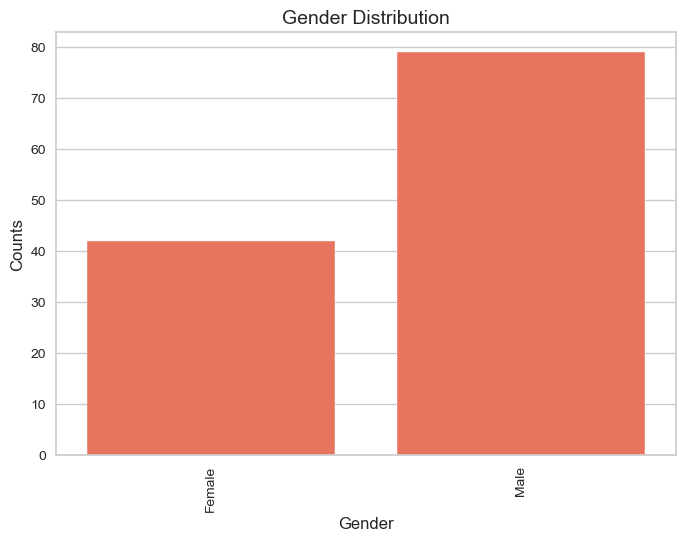

In [33]:
sns.set_style('whitegrid')

sns.countplot(x='Gender', data=df, color='#FF6347')

plt.title('Gender Distribution', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Counts', fontsize=12)

plt.xticks([0, 1], ['Female', 'Male'], rotation=90)

plt.show()

Observem que hi ha molts més **personatges** que són **homes**.

A continuació, mirarem com és la **distrubució** per **Job** del nostre Dataset.

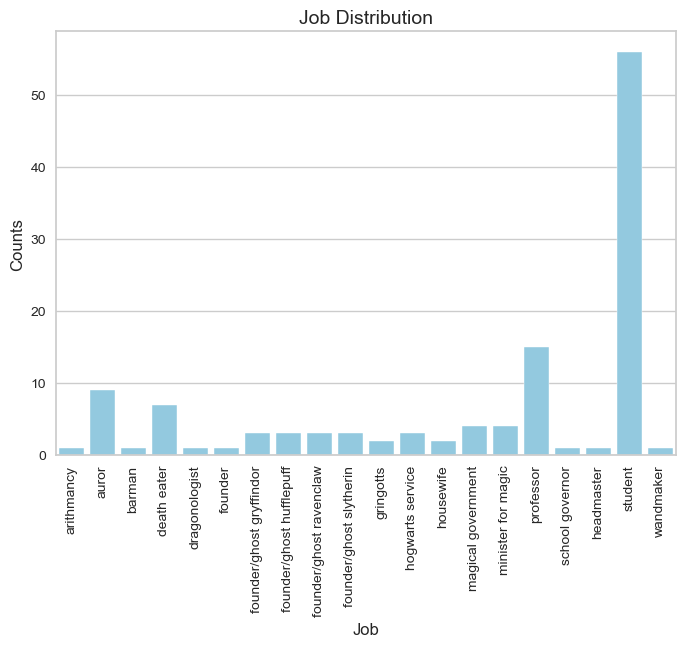

In [34]:
sns.set_style('whitegrid')

sns.countplot(x='Job', data=df, color='#87CEEB')

plt.title('Job Distribution', fontsize=14)
plt.xlabel('Job', fontsize=12)
plt.ylabel('Counts', fontsize=12)

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], ['arithmancy', 'auror', 'barman', 'death eater', 'dragonologist', 'founder', 'founder/ghost gryffindor', 'founder/ghost hufflepuff', 'founder/ghost ravenclaw', 'founder/ghost slytherin', 'gringotts', 'hogwarts service', 'housewife', 'magical government', 'minister for magic', 'professor', 'school governor', 'headmaster', 'student', 'wandmaker'], rotation=90)

plt.show()

Observem que la **feina** més **freqüent** és la d'**estudiant**, això ens quadra ja que la història es centra en **Hogwarts School**.

A continuació, mirarem com és la **distrubució** per **House** del nostre Dataset.

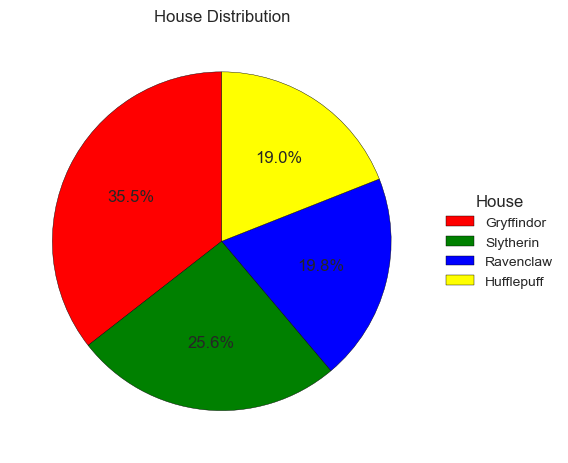

In [35]:
house_counts = df['House'].value_counts()

colors = ['#FF0000', '#008000', '#0000FF', '#FFFF00']

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(house_counts, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})

ax.legend(wedges, ['Gryffindor', 'Slytherin', 'Ravenclaw', 'Hufflepuff'], title="House", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('House Distribution')

plt.show()

Observem que la majoria de **personatges** pertanyen a la **casa** de **Gryffindor**, seguida per la de **Slytherin**.

A continuació, mirarem com és la **distrubució** per **Species** del nostre Dataset.

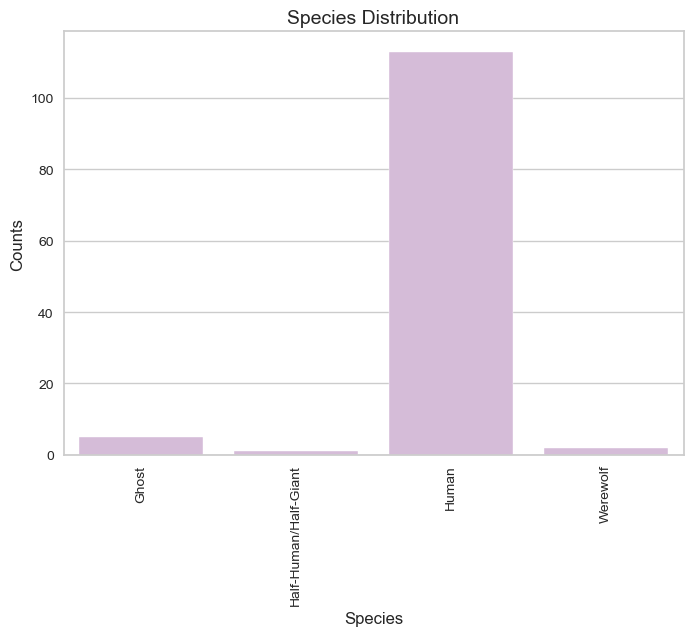

In [36]:
sns.set_style('whitegrid')

sns.countplot(x='Species', data=df, color='#D8B7DD')

plt.title('Species Distribution', fontsize=14)
plt.xlabel('Species', fontsize=12)
plt.ylabel('Counts', fontsize=12)

plt.xticks([0, 1, 2, 3,], ['Ghost', 'Half-Human/Half-Giant', 'Human', 'Werewolf'], rotation=90)

plt.show()

Veiem que la majoria dels **personatges** pertanyen a l'espècie de **Human**.

A continuació, mirarem com és la **distrubució** per **Blood status** del nostre Dataset.

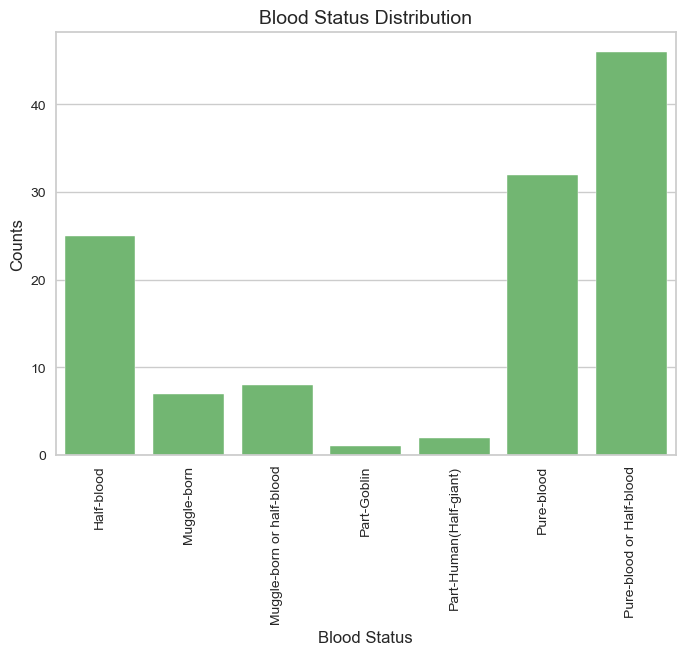

In [37]:
sns.set_style('whitegrid')

sns.countplot(x='Blood status', data=df, color='#66C266')

plt.title('Blood Status Distribution', fontsize=14)
plt.xlabel('Blood Status', fontsize=12)
plt.ylabel('Counts', fontsize=12)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Half-blood', 'Muggle-born', 'Muggle-born or half-blood', 'Part-Goblin', 'Part-Human(Half-giant)', 'Pure-blood', 'Pure-blood or Half-blood'], rotation=90)

plt.show()

Veiem que la majoria dels **personatges** tenen com a **Blood status**, **Pure-blood or Half-blood**.

A més a més, mirarem com és la **distrubució** de **Loyalty**, agafant 4 valors diferents d'aquesta característica, i ho compararem amb la característica **House**. D'aquesta manera, podrem determinar quina de les cases és més lleial a una certa persona.

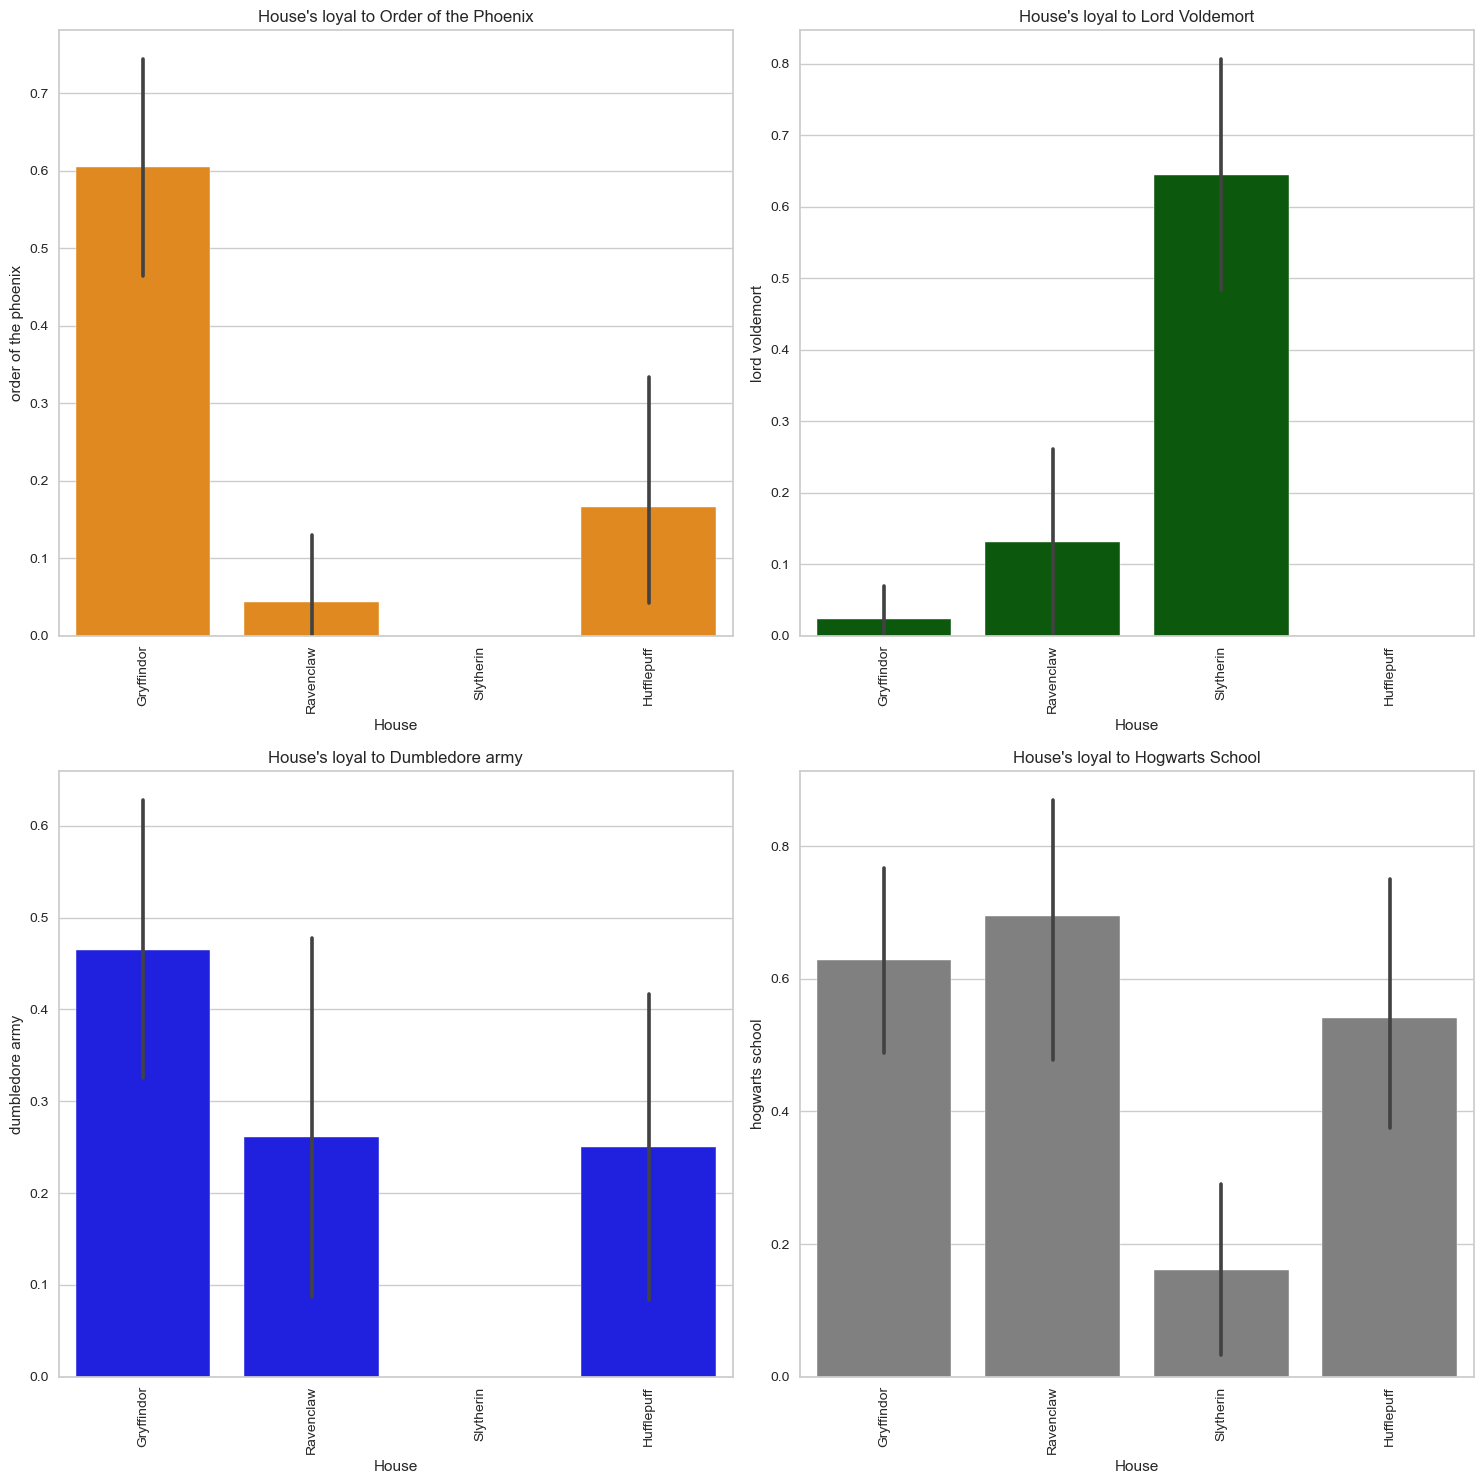

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

sns.barplot(x="House", y="order of the phoenix", data=df, ax=axes[0, 0], color='#FF8C00')
axes[0, 0].set_title("House's loyal to Order of the Phoenix")
axes[0, 0].tick_params(axis='x', rotation=90)

sns.barplot(x="House", y="lord voldemort", data=df, ax=axes[0, 1], color='#006400')
axes[0, 1].set_title("House's loyal to Lord Voldemort")
axes[0, 1].tick_params(axis='x', rotation=90)

sns.barplot(x="House", y="dumbledore army", data=df, ax=axes[1, 0], color='#0000FF')
axes[1, 0].set_title("House's loyal to Dumbledore army")
axes[1, 0].tick_params(axis='x', rotation=90)

sns.barplot(x="House", y="hogwarts school", data=df, ax=axes[1, 1], color='#808080')
axes[1, 1].set_title("House's loyal to Hogwarts School")
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Respecte a les **cases** que són lleials a **Order of the Phoenix**, veiem que la casa **Gryffindor** és la més lleial.

Si mirem la gràfica de les **cases** més lleials a **Lord Voldemort**, obervem que és la casa **Slytherin**. Te bastant sentit, ja que la majoria de personatges d'aquesta casa, sabem que estàn a favor de **Lord Voldemort**.

També podem veure que totes les **cases** excepte la de **Slytherin**, són lleials a **Dumbledore army**, cosa que ens quadra amb la gràfica anterior. Ja que els personatges que són lleials a **Dumbledore army**, no són lleials a **Lord Voldemort**.

Per últim, observem també que totes les cases són lleials a **Hogwarts School**. Algunes ho són més, com **Ravenclaw** i **Gryffindor**, i n'hi ha algunes que no tant, com **Slytherin**.

Per últim, mirarem la **correlació** entre totes les **característiques**:

Però primer, haurem de fer **encoding** de la caracterísitca **House**.

In [39]:
numeric_features = df.select_dtypes(np.number).keys()
non_numeric = ['House']
le = LabelEncoder()
df.loc[:,non_numeric] = df.loc[:,non_numeric].apply(le.fit_transform)
df.head()

,Id,Gender,Job,House,Species,Blood status,Hair colour,Eye colour,parsel,wizard chess,...,albus dumbledore,dumbledore army,order of the phoenix,lord voldemort,hogwarts school,ministry,family,minister,hogsmeade,gringotts
120,1,1,18,0,2,0,2,4,1,0,...,1,1,1,0,1,0,0,0,0,0
105,2,1,18,0,2,5,15,1,0,1,...,0,1,1,0,1,0,0,0,0,0
106,3,0,18,0,2,1,5,5,0,0,...,0,1,1,0,1,0,0,0,0,0
107,4,1,17,0,2,0,20,1,0,0,...,0,1,1,0,1,0,0,0,0,0
108,5,1,15,0,1,4,2,0,0,0,...,1,0,1,0,1,0,0,0,0,0


Ara ja podem fer el **gràfic** de **correlacions**.

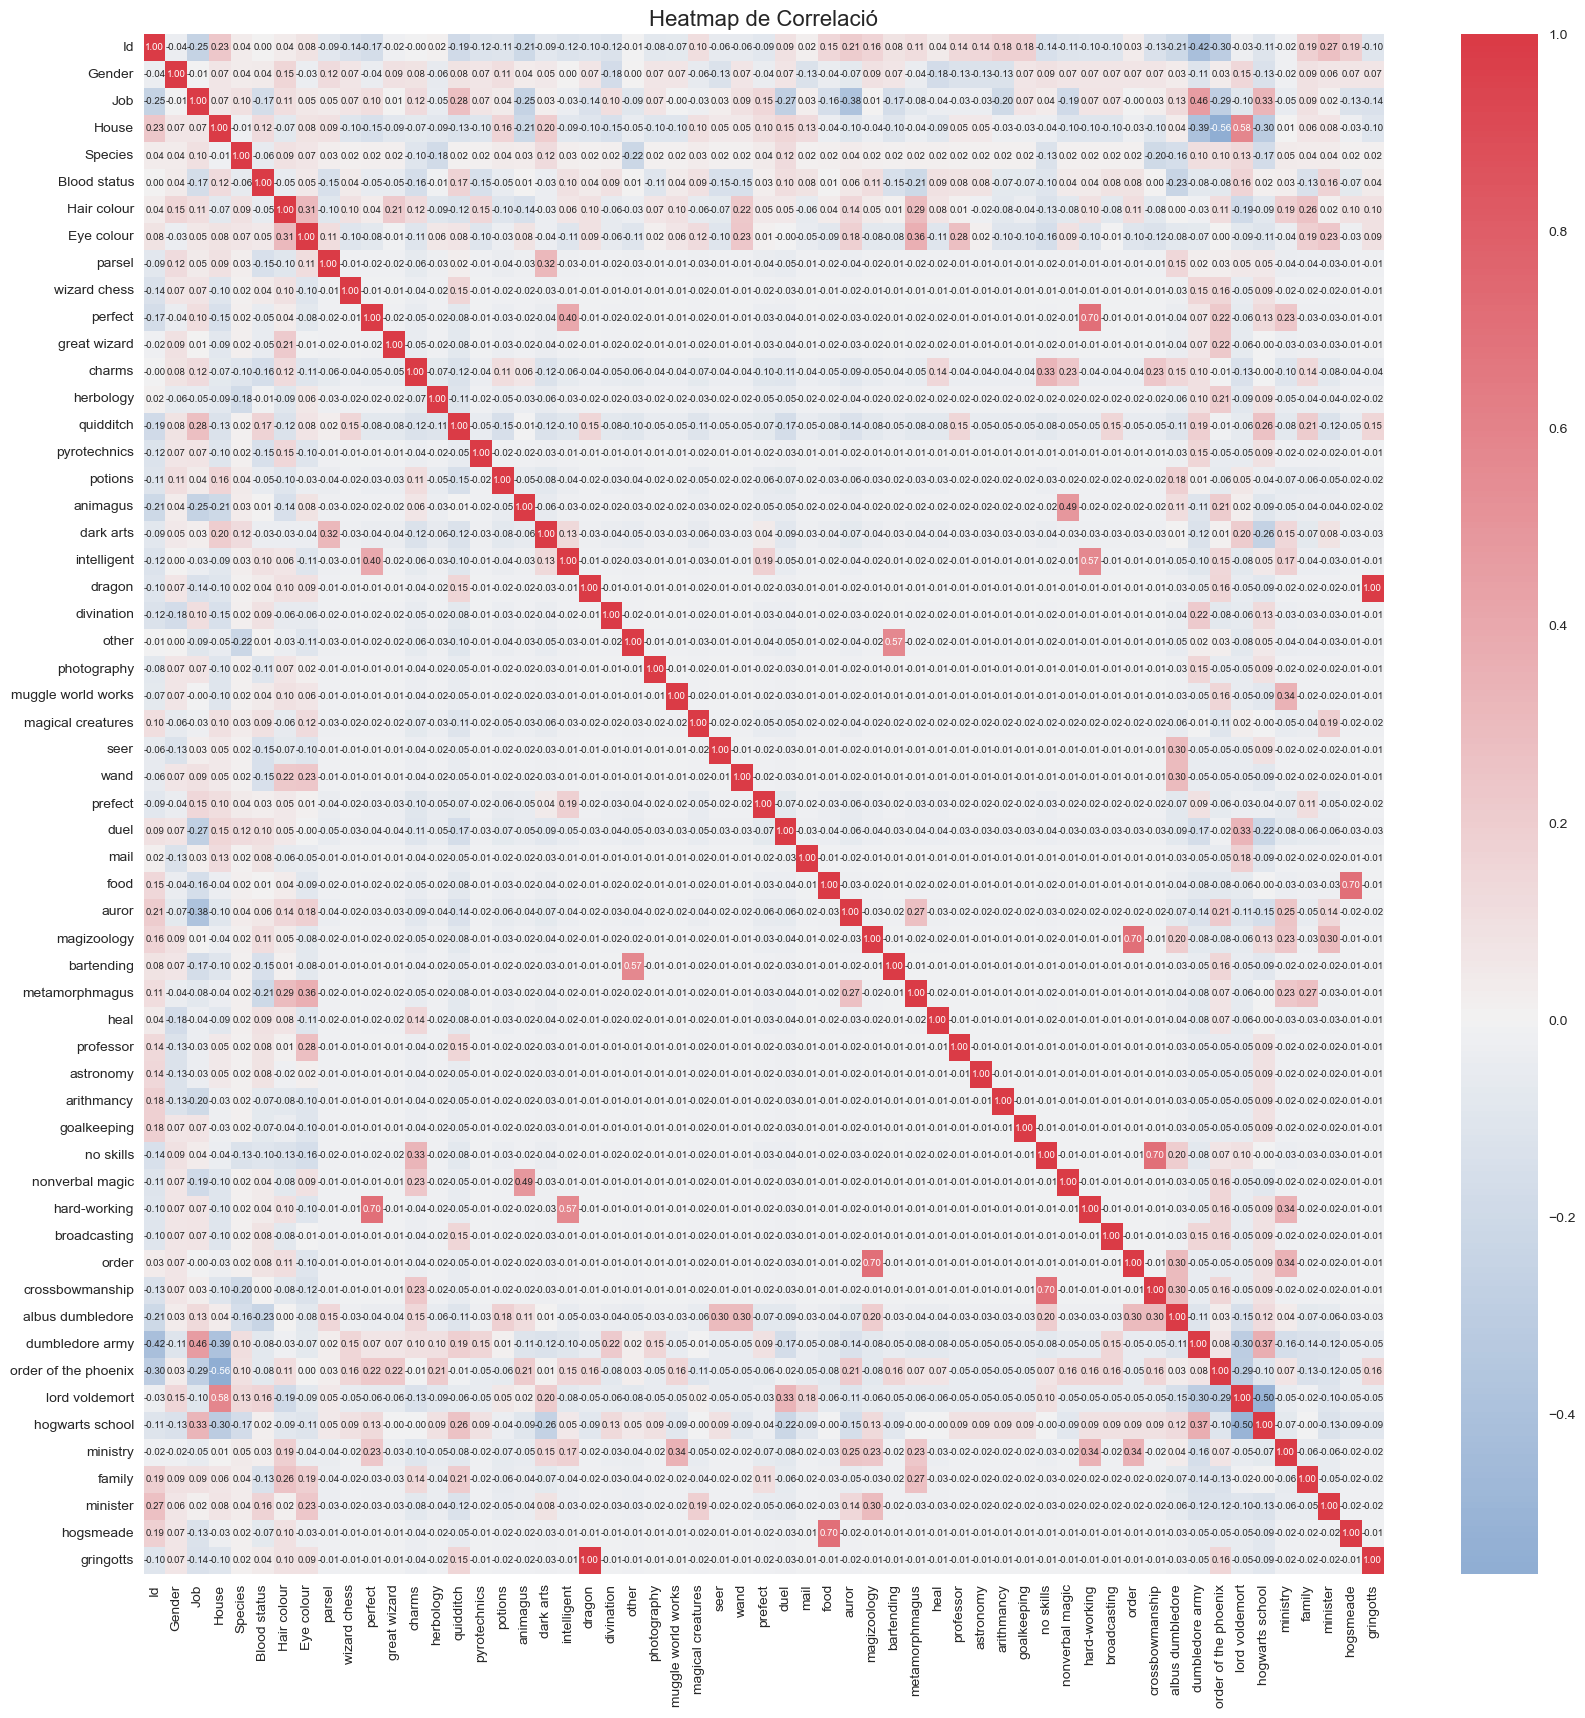

In [40]:
sns.set_style('whitegrid')

plt.figure(figsize=(20, 20))

palette = sns.diverging_palette(250, 10, as_cmap=True)

sns.heatmap(df.corr(), cmap=palette, annot=True, fmt=".2f", center=0, annot_kws={"size": 7})

plt.title('Heatmap de Correlació', fontsize=16)

plt.show()

Observem que les **característiques** més **correlacionades** amb la variable target **House** són:

* **Lord Voldemort** (0.58)
* **Order of the Phoenix** (-0.56)
* **Dumbledore Army** (-0.39)
* **Hogwarts School** (-0.30)
* **Dark Arts** (0.20)

# 3. NORMALIZATION

**Normalitzem** les dades. En concret, els atributs **Job**, **Species**, **Blood Status**, **Hair colour** i **Eye colour**.

In [41]:
numerical_columns=['Job', 'Species', 'Blood status', 'Hair colour', 'Eye colour']
sc = StandardScaler()
train_norm=sc.fit_transform(df.loc[:,numerical_columns])

df[numerical_columns]=train_norm
df.head()

,Id,Gender,Job,House,Species,Blood status,Hair colour,Eye colour,parsel,wizard chess,...,albus dumbledore,dumbledore army,order of the phoenix,lord voldemort,hogwarts school,ministry,family,minister,hogsmeade,gringotts
120,1,1,0.794445,0,0.173141,-1.603097,-0.919276,-0.322788,1,0,...,1,1,1,0,1,0,0,0,0,0
105,2,1,0.794445,0,0.173141,0.460464,1.042760,-1.098762,0,1,...,0,1,1,0,1,0,0,0,0,0
106,3,0,0.794445,0,0.173141,-1.190385,-0.466498,-0.064130,0,0,...,0,1,1,0,1,0,0,0,0,0
107,4,1,0.627846,0,0.173141,-1.603097,1.797390,-1.098762,0,0,...,0,1,1,0,1,0,0,0,0,0
108,5,1,0.294647,0,-2.154643,0.047752,-0.919276,-1.357420,0,0,...,1,0,1,0,1,0,0,0,0,0


A més, **eliminarem** la columna **Id**, ja que no ens aporta informació.

In [42]:
df = df.drop(columns=['Id'])

df.head()

,Gender,Job,House,Species,Blood status,Hair colour,Eye colour,parsel,wizard chess,perfect,...,albus dumbledore,dumbledore army,order of the phoenix,lord voldemort,hogwarts school,ministry,family,minister,hogsmeade,gringotts
120,1,0.794445,0,0.173141,-1.603097,-0.919276,-0.322788,1,0,0,...,1,1,1,0,1,0,0,0,0,0
105,1,0.794445,0,0.173141,0.460464,1.042760,-1.098762,0,1,0,...,0,1,1,0,1,0,0,0,0,0
106,0,0.794445,0,0.173141,-1.190385,-0.466498,-0.064130,0,0,1,...,0,1,1,0,1,0,0,0,0,0
107,1,0.627846,0,0.173141,-1.603097,1.797390,-1.098762,0,0,0,...,0,1,1,0,1,0,0,0,0,0
108,1,0.294647,0,-2.154643,0.047752,-0.919276,-1.357420,0,0,0,...,1,0,1,0,1,0,0,0,0,0


# 4. FEATURES SELECTION

Per fer la selecció de features, aplicarem primer la **regularització** de **Lasso**:

Best alpha: 0.05
Best test r2_score: 0.5281793737352375
Features seleccionades: ['order of the phoenix', 'lord voldemort']


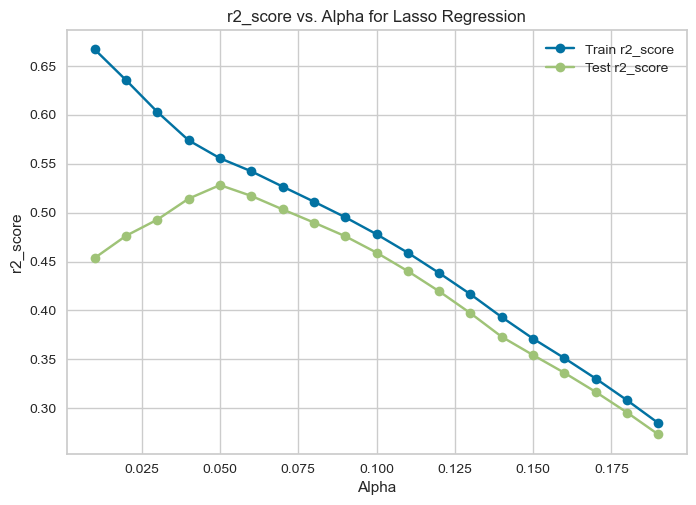

In [43]:
target = 'House'
attributes = [k for k in df.keys() if k != target]
X = df[attributes]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# Diferents valors de alpha
alphas = np.arange(0.01, 0.2, 0.01)
r2_score_train_list = []
r2_score_test_list = []

best_alpha = None
best_r2_score = -float('inf')

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    
    # Prediccions
    y_pred_train = lasso.predict(X_train)
    y_pred_test = lasso.predict(X_test)
    
    # Calcular r2_score
    r2_score_train = r2_score(y_train, y_pred_train)
    r2_score_test = r2_score(y_test, y_pred_test)
    r2_score_train_list.append(r2_score_train)
    r2_score_test_list.append(r2_score_test)
    
    # Actualitzar valors
    if r2_score_test > best_r2_score:
        best_alpha = alpha
        best_r2_score = r2_score_test

print(f"Best alpha: {best_alpha}")
print(f"Best test r2_score: {best_r2_score}")

features_lasso = X_train.columns[(lasso.coef_ != 0)]
print(f"Features seleccionades: {list(features_lasso)}")

plt.plot(alphas, r2_score_train_list, label="Train r2_score", marker='o')
plt.plot(alphas, r2_score_test_list, label="Test r2_score", marker='o')
plt.xlabel('Alpha')
plt.ylabel('r2_score')
plt.title('r2_score vs. Alpha for Lasso Regression')
plt.legend()
plt.show()

Observem que la **regularització** de **Lasso** ens selecciona les **característiques** *['order of the phoenix', 'lord voldemort']*

El segon **mètode** que aplicarem serà el de **l'eliminació recursiva de característiques (RFE)**. **RFE** treballa entrenant un model, evaluant la importància de cada característica i eliminant les menys importants fins que arriba a un nombre concret de característiques.

In [44]:
df['House'] = le.inverse_transform(df['House'].astype(int))

X = df.drop(columns=['House'])
y = df['House']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

lr = LogisticRegression(random_state=15)

# Apliquem RFE per seleccionar les millors característiques
rfe = RFE(estimator=lr)
rfe.fit(X_train, y_train)

# Característiques seleccionades
features_rfe = X_train.columns[rfe.support_]
print(f'Característiques seleccionades: {list(features_rfe)}')

Característiques seleccionades: ['Gender', 'Job', 'Eye colour', 'parsel', 'charms', 'herbology', 'quidditch', 'potions', 'animagus', 'dark arts', 'intelligent', 'divination', 'other', 'seer', 'prefect', 'duel', 'food', 'magizoology', 'metamorphmagus', 'goalkeeping', 'no skills', 'dumbledore army', 'order of the phoenix', 'lord voldemort', 'hogwarts school', 'family', 'minister']


Per últim farem l'entrenament del model sense **selecció** de **features**:

In [45]:
lr_base = LogisticRegression(random_state=15)
lr_base.fit(X_train, y_train)
y_pred_base = lr_base.predict(X_test)
print(classification_report(y_test, y_pred_base, zero_division=0))

              precision    recall  f1-score   support

  Gryffindor       0.62      1.00      0.76         8
  Hufflepuff       0.25      0.20      0.22         5
   Ravenclaw       0.50      0.40      0.44         5
   Slytherin       1.00      0.57      0.73         7

    accuracy                           0.60        25
   macro avg       0.59      0.54      0.54        25
weighted avg       0.63      0.60      0.58        25



A continuació, farem l'entrenament del model amb les característiques seleccionades.

**Lasso**:

In [46]:
X_train_lasso = X_train[features_lasso]
X_test_lasso = X_test[features_lasso]

# Reentrenem el model de Logistic Regression amb les característiques seleccionades per Lasso
lr_lasso = LogisticRegression(random_state=15)
lr_lasso.fit(X_train_lasso, y_train)

y_pred_lasso = lr_lasso.predict(X_test_lasso)

**RFE**:

In [47]:
X_train_rfe = X_train[features_rfe]
X_test_rfe = X_test[features_rfe]

# Reentrenem el model de Logistic Regression amb les característiques seleccionades per RFE
lr_rfe = LogisticRegression(random_state=15)
lr_rfe.fit(X_train_rfe, y_train)

y_pred_rfe = lr_rfe.predict(X_test_rfe)

Comparació del **tres models** entrenats:

In [48]:
metrics = {
    'Precisió': precision_score,
    'Recall': recall_score,
    'F1 Score': f1_score
}
averages = ['micro', 'macro', 'weighted']

models = {
    'Sense selecció de features': y_pred_base,
    'RFE': y_pred_rfe,
    'Lasso': y_pred_lasso
}

resultats = {model_name: {f'{metric_name} ({avg})': [] for metric_name in metrics for avg in averages} for model_name in models}

# Comparem les mètriques per a cada model
for model_name, y_pred_actual in models.items():
    for metric_name, metric_func in metrics.items():
        for avg in averages:
            score = metric_func(y_test, y_pred_actual, average=avg, zero_division=0)
            resultats[model_name][f'{metric_name} ({avg})'].append(score)

results_df = pd.DataFrame(resultats)

print("\nComparació de mètriques:")

results_df


Comparació de mètriques:


,Sense selecció de features,RFE,Lasso
Precisió (micro),[0.6],[0.64],[0.52]
Precisió (macro),[0.5913461538461539],[0.6538461538461539],[0.47916666666666663]
Precisió (weighted),[0.6269230769230769],[0.676923076923077],[0.5433333333333333]
Recall (micro),[0.6],[0.64],[0.52]
Recall (macro),[0.5428571428571429],[0.5928571428571427],[0.48035714285714287]
Recall (weighted),[0.6],[0.64],[0.52]
F1 Score (micro),[0.6],[0.64],[0.52]
F1 Score (macro),[0.5389610389610389],[0.58008658008658],[0.446524064171123]
F1 Score (weighted),[0.5807792207792207],[0.6136796536796537],[0.5001069518716578]


Observem que utilitzant un **model** amb les **features** trobades amb el mètode **RFE**, obtenim millors resultats. Per tant, **aplicarem** la **selecció de features** que ha realitzat el mètode **RFE**.

# 5. METRIC SELECTION

Com que en l'apartat anterior hem obtingut que utilizant les **característiques** *['Gender', 'Job', 'Eye colour', 'parsel', 'charms', 'herbology', 'quidditch', 'potions', 'animagus', 'dark arts', 'intelligent', 'divination', 'other', 'seer', 'prefect', 'duel', 'food', 'magizoology', 'metamorphmagus', 'goalkeeping', 'no skills', 'dumbledore army', 'order of the phoenix', 'lord voldemort', 'hogwarts school', 'family', 'minister']*, ens donava un **millor resultat**, per fer la selecció de la mètrica ho farem tenint en compte aquestes característiques.

In [49]:
lr = LogisticRegression(random_state=15)

lr.fit(X_train_rfe, y_train)

y_pred = lr.predict(X_test_rfe)
classification = classification_report(y_test, y_pred, zero_division=0)

print("Provem les diferents mètriques: \n")

precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f'Precisió (Micro): {precision_micro}')
print(f'Precisió (Macro): {precision_macro}')
print(f'Precisió (weighted): {precision_weighted}')
print(f'Recall (Micro): {recall_micro}')
print(f'Recall (Macro): {recall_macro}')
print(f'Recall (weighted): {recall_weighted}')
print(f'F1 Score (Micro): {f1_micro}')
print(f'F1 Score (Macro): {f1_macro}')
print(f'F1 Score (weighted): {f1_weighted}\n')

print(classification)

Provem les diferents mètriques: 

Precisió (Micro): 0.64
Precisió (Macro): 0.6538461538461539
Precisió (weighted): 0.676923076923077
Recall (Micro): 0.64
Recall (Macro): 0.5928571428571427
Recall (weighted): 0.64
F1 Score (Micro): 0.64
F1 Score (Macro): 0.58008658008658
F1 Score (weighted): 0.6136796536796537

              precision    recall  f1-score   support

  Gryffindor       0.62      1.00      0.76         8
  Hufflepuff       0.50      0.20      0.29         5
   Ravenclaw       0.50      0.60      0.55         5
   Slytherin       1.00      0.57      0.73         7

    accuracy                           0.64        25
   macro avg       0.65      0.59      0.58        25
weighted avg       0.68      0.64      0.61        25



Hem calculat les mètriques de **precisió**, **recall** i **f1_score** utilitzat els promigs **Micro**, **Macro** i **Weighted**.

Els resultats obtinguts han estat millors fent servir el promig **Weighted** amb **Precision**.

Però com que el nostre conjunt de dades és **desbalançejat**, utilitzarem la mètrica **f1_score** amb el promig **Micro**, ja que funciona bé per a aquest tipus de dades.

# 6. MODEL SELECTION

Trobem el **millor model** amb els hyperparameters per defecte, utilitzant **validació creuada**.

En el nostre cas és millor utilitzar **StratifiedKFold**, ja que garanteix que cada "fold" tingui una distribució similar de la classe objectiu (la proporció de les cases es manté constant).

Logistic Regression: F1 score mitjana en CV = 0.6540
SVM: F1 score mitjana en CV = 0.6367
Random Forest: F1 score mitjana en CV = 0.6867
Gradient Boosting Classifier: F1 score mitjana en CV = 0.6120
Decision Tree Classifier: F1 score mitjana en CV = 0.5703


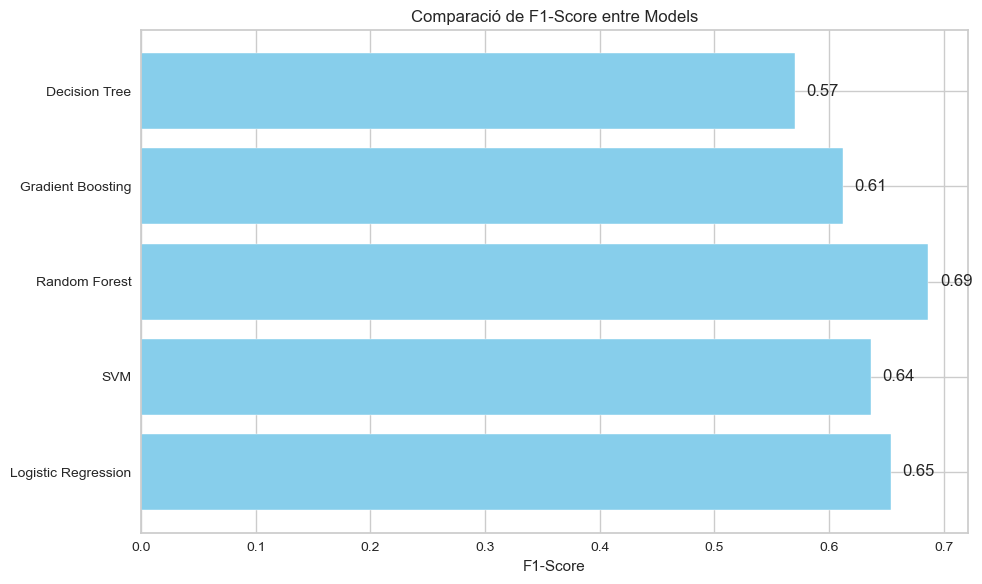

In [50]:
def f1_score_comparison(models, f1_scores):
    plt.figure(figsize=(10, 6))
    plt.barh(models, f1_scores, color='skyblue')

    plt.xlabel('F1-Score')
    plt.title('Comparació de F1-Score entre Models')

    for i, v in enumerate(f1_scores):
        plt.text(v + 0.01, i, f"{v:.2f}", va='center')

    plt.tight_layout()
    plt.show()

models=['Logistic Regression', 'SVM', 'Random Forest', 'Gradient Boosting', 'Decision Tree']
f1_scores=[]

models2 = {
    'Logistic Regression': LogisticRegression(random_state=15),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(random_state=15),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=15),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=15)
}

y = le.fit_transform(y)

f1_scores=[]
for name, model in models2.items():
    scores = cross_val_score(model, X[features_rfe], y, cv = StratifiedKFold(n_splits = 5, random_state=15, shuffle=True), scoring = 'f1_micro')
    print(f'{name}: F1 score mitjana en CV = {scores.mean():.4f}')
    f1_scores.append(scores.mean())

f1_score_comparison(models, f1_scores)

Observem que el millor model és el **Random Forest** amb un **f1_score** de **0.69**.

# 7. HYPERPARAMETERS SEARCH

Trobem els **millors hyperparameters** per cada model utilitzant **Grid search**. 

In [51]:
param_grid =  {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10]
}
"""
lr = RandomForestClassifier(random_state=15)
start_time = time.time()
grid_search_rf = GridSearchCV(lr, param_grid, cv=StratifiedKFold(n_splits = 5, random_state=15, shuffle=True), scoring='f1_micro')
grid_search_rf.fit(X_train_rfe, y_train)
end_time = time.time()
total_time = end_time - start_time
best_parameters = grid_search_rf.best_params_
print(f"Temps d'execució: {total_time} segons")
print(f'Millors hiperparàmetres: {best_parameters}')
print(f'Millor score: {grid_search_rf.best_score_:.4f}')
"""

'\nlr = RandomForestClassifier(random_state=15)\nstart_time = time.time()\ngrid_search_rf = GridSearchCV(lr, param_grid, cv=StratifiedKFold(n_splits = 5, random_state=15, shuffle=True), scoring=\'f1_micro\')\ngrid_search_rf.fit(X_train_rfe, y_train)\nend_time = time.time()\ntotal_time = end_time - start_time\nbest_parameters = grid_search_rf.best_params_\nprint(f"Temps d\'execució: {total_time} segons")\nprint(f\'Millors hiperparàmetres: {best_parameters}\')\nprint(f\'Millor score: {grid_search_rf.best_score_:.4f}\')\n'

Calculem l'**f1_score** utilitzant el hyperparameters seleccionats.

In [52]:
scores = cross_val_score(RandomForestClassifier(max_depth = None, max_features = 'sqrt', min_samples_split = 2, n_estimators = 300, random_state=15), X[features_rfe], y, cv = StratifiedKFold(n_splits = 5, random_state=15, shuffle=True), scoring = 'f1_micro')
print(f'RF (Hyperparameters) : F1 score mitjana en CV = {scores.mean():.4f}')

scores = cross_val_score(RandomForestClassifier(random_state=15), X[features_rfe], y, cv = StratifiedKFold(n_splits = 5, random_state=15, shuffle=True), scoring = 'f1_micro')
print(f'RF : F1 score mitjana en CV = {scores.mean():.4f}')

RF (Hyperparameters) : F1 score mitjana en CV = 0.6867
RF : F1 score mitjana en CV = 0.6867


Observem que amb la utilització dels **hyperparameters**, obtenim un **f1_score** més alt, per tant, els utilitzarem en l'anàlisi final.

# 8. FINAL ANALYSIS

A continuació, farem la predicció de **House** per a cada **personatge**.

En primer lloc, separem el **target** i les **característiques**.

In [53]:
X = df[features_rfe]
y = df['House']

**ROC i PR curve**

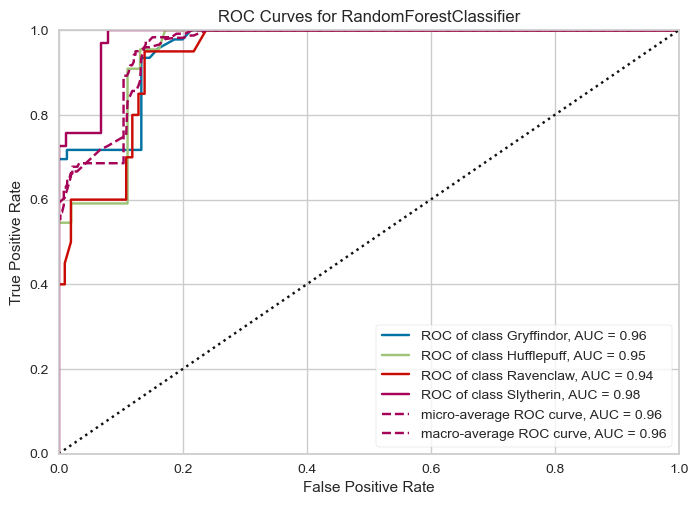

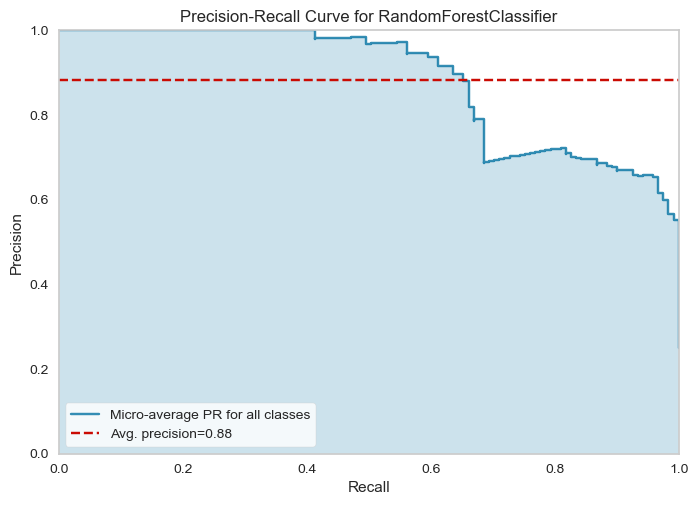

<Axes: title={'center': 'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [54]:
df['House'] = le.fit_transform(df['House'])

target = 'House'
X = df[features_rfe]
y = df[target]

model = RandomForestClassifier(max_depth = None, max_features = 'sqrt', min_samples_split = 2, n_estimators = 300, random_state=15)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
y_pred = cross_val_predict(model, X, y, cv=cv)

# Corba ROC
roc = ROCAUC(model, classes=['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin'])
roc.fit(X, y)
roc.score(X, y_pred)
roc.show()

# Corba PR
pr = PrecisionRecallCurve(model, classes=['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin'])
pr.fit(X, y)
pr.score(X, y_pred)
pr.show()

#### **Corba ROC**

  La corba ROC mostra la relació entre la taxa de false positives i la taxa de ture positives per a cada classe.

- **Corba ROC per a cada classe:**
  - **Gryffindor:** AUC = 0.96. Això ens indica que hi ha una molt bona capacitat de classificació.
  - **Hufflepuff:** AUC = 0.95. En aquest cas, també té una molt bona precisió.
  - **Ravenclaw:** AUC = 0.94. En canvi, l'AUC d'aquesta classe també és alt, però una mica inferior comparats amb l'AUC d'altres classes.
  - **Slytherin:** AUC = 0.98. Observem que és la classe que té l'AUC més alt, per tant, té la millor capacitat de classificació.

- **AUC global:**
  - **Micro-average AUC:** 0.96. Això significa que considera totes les classes globalment, indicant un bon rendiment general.
  - **Macro-average AUC:** 0.96. En aquest cas, indica el promig simple dels AUC de cada classe, indicant que el model no es veu afectat per desequilibris entre classes.

El model RandomForestClassifier té una excel·lent capacitat de discriminació per a totes les classes. Les corbes estan molt a prop de l'extrem superior esquerra, indicant un alt rendiment en termes de predicció correcta i pocs false positives.

#### **Corba Precision-Recall**

Aquesta corba mostra la relació entre la precisió i el recall per a diferents llindars. És útil en el nostre cas, ja que el dataset del que disposem és desequilibrat i es centra més en la classe positiva.

**Average precision:** 0.88. El valor mitjà de precisió mostra que, globalment, el model és capaç de fer prediccions amb una precisió força alta.

La corba comença amb una precisió alta (al voltant de 1.0) per valors baixos de recall i després disminueix a mesura que el recall augmenta. Això significa que el model és precís quan només prediu les instàncies més segures, però la precisió disminueix quan es fa més tolerant a false negatives (augmentant el recall).
  
Aquesta corba mostra mostra que el model té una bona precisió global però que pot perdre rendiment a mesura que intenta recuperar més instàncies positives. Això suggereix que és robust en contextos on es necessita precisió alta.

**Confusion Matrix**

Utilitzarem les prediccions del classificador **Random Forest** amb la mètrica **F1_score** i el promig **Micro**, ja que ens ha donat millors resultats en l'anàlisi anterior.

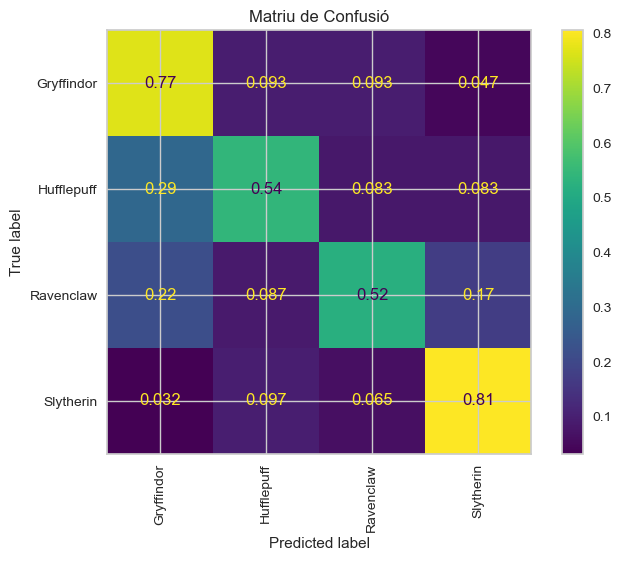

F1 Score (Micro): 0.6860


In [55]:
# Convertim  la columna House als seus valors originals
y = le.inverse_transform(y)
y_pred = le.inverse_transform(y_pred.astype(int))

confusion = ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true')
plt.xticks(rotation=90)
plt.title("Matriu de Confusió")
plt.show()

# Càlcul de F1 Score (Micro)
f1_micro = f1_score(y, y_pred, average='micro')
print(f"F1 Score (Micro): {f1_micro:.4f}")

La matriu de confusió mostra el rendiment del classificador en cada categoria (les quatre cases de Hogwarts: Gryffindor, Hufflepuff, Ravenclaw i Slytherin). Cada fila representa les classes reals, mentre que cada columna representa les classes predites.

#### **Prediccions correctes:**
- **Gryffindor:**  
  - Prediccions correctes: **77%**  
  - El classificador encerta bé en predir Gryffindor, tot i que té un 23% d'errors.

- **Hufflepuff:**  
  - Prediccions correctes: **54%**  
  - Aquest percentatge és més baix, el que indica que Hufflepuff té més dificultats per ser correctament classificat. Ja que algunes característiques són similars amb les de la casa Gryffindor.

- **Ravenclaw:**  
  - Prediccions correctes: **52%**  
  - Similar a Hufflepuff, Ravenclaw també té una taxa d'encert baixa i sovint es classifica com Gryffindor, i fins i tot amb Slytherin.

- **Slytherin:**  
  - Prediccions correctes: **81%**  
  - Aquesta és la classe amb la millor precisió. Slytherin té menys confusions amb altres classes, demostrant que el model distingeix bé aquesta casa. Això significa que aquesta casa té patrons més distintius.

#### **Conclusions:**

  El model és molt bo per predir Slytherin, amb una taxa d’encert del 81%. També funciona bastant bé amb Gryffindor.

  En canvi, el model té més dificultats per classificar correctament Hufflepuff i Ravenclaw. La confusió amb Gryffindor podria indicar una manca de diferenciació clara en les característiques de les dades entre aquestes cases.

Algunes de les millores que es podrien dur a terme serien, ajustar el model per donar més pes a les classes amb més errors.

Per últim, analitzarem el **classification report** del nostre model:

In [56]:
report = classification_report(y, y_pred)
print("Informe de Classificació:")
print(report)

Informe de Classificació:
              precision    recall  f1-score   support

  Gryffindor       0.72      0.77      0.74        43
  Hufflepuff       0.59      0.54      0.57        24
   Ravenclaw       0.60      0.52      0.56        23
   Slytherin       0.76      0.81      0.78        31

    accuracy                           0.69       121
   macro avg       0.67      0.66      0.66       121
weighted avg       0.68      0.69      0.68       121



La funció **classification_report** ens mostra les mètriques principals de classificació: accuracy, presicion, recall i f1-score. Ens centrarem sobretot en la **f1 score** per tal d'optimitzar el nostre classificador.

**Classes:**
- **Gryffindor**:
  - *Precision*: 0.72 — El 72% de les vegades que el model ha predit Gryffindor, ha encertat.
  - *Recall*: 0.77 — El model ha indetificat correctament el 77% dels casos reals de Gryffindor.
  - *F1-score*: 0.74 — Equilibri raonable entre precisió i recall.

- **Hufflepuff:**
  - *Precision*: 0.59 — Només el 59% de les prediccions de Hufflepuff han estat correctes.
  - *Recall*: 0.54 — El 54% dels casos reals de Hufflepuff s'han identificar correctament.
  - *F1-score*: 0.57 — Rendiment moderat.

- **Ravenclaw:**
  - *Precision*: 0.60 — 60% de precisió per Ravenclaw.
  - *Recall*: 0.52 — Només la meitat dels casos reals s'han detectat.
  - *F1-score*: 0.56 — Rendiment moderat.

- **Slytherin:**
  - *Precision*: 0.76 — Bastant nivell de precisió.
  - *Recall*: 0.81 — El model ha identificat el 81% dels casos correctament.
  - *F1-score*: 0.78 — Bon equilibri entre precisió i recall.

### **Mètriques:**
- **Accuracy**: 0.69  
  Això significa que el model encerta en el 69% de les prediccions. No és perfecte, però mostra un rendiment decent per un conjunt de quatre classes.

- **Macro avg:**
  - **Precision**: 0.67 — Mitjana de la precisió per totes les classes, sense ponderar.
  - **Recall**: 0.66 — Mitjana dels recall per totes les classes.
  - **F1-score**: 0.66 — Mitjana general equilibrada entre precisió i recall.

- **Weighted avg:**  
  Això té en compte el nombre de mostres per classe:
  - **Precision**: 0.68  
  - **Recall**: 0.69  
  - **F1-score**: 0.68  

### **Conclusió:**
- El model funciona millor en la classificació de **Gryffindor** i **Slytherin**, amb puntuacions més altes de precisió i recall.
- Té dificultats amb les classes de **Hufflepuff** i **Ravenclaw**, cosa que podria indicar un desequilibri en les dades o característiques que no són suficientment distintives.